In [1]:
suppressPackageStartupMessages({
  library(quantmod)
  library(dplyr)
  library(lubridate)
})

# Define stock tickers and date range
tickers <- c("AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", 
             "NVDA", "META", "JPM", "V", "WMT", 
             "JNJ", "PG", "MA", "DIS", "NFLX")

start_date <- "2000-01-01"
end_date <- "2024-12-31"

# Function to download complete stock data
get_stock_data <- function(ticker, start, end) {
  tryCatch({
    stock_data <- getSymbols(ticker, src = "yahoo", 
                            from = start, to = end, 
                            auto.assign = FALSE)
    
    prices <- Ad(stock_data)
    volumes <- Vo(stock_data)
    
    qtr_ends <- endpoints(prices, on = "quarters")
    qtr_ends <- qtr_ends[qtr_ends > 0]
    
    qtr_prices <- prices[qtr_ends]
    qtr_returns <- (qtr_prices / lag(qtr_prices) - 1) * 100
    qtr_returns <- qtr_returns[-1]
    
    qtr_volume <- period.apply(volumes, INDEX = qtr_ends, FUN = mean)
    qtr_volume <- qtr_volume[-1]
    
    daily_returns <- dailyReturn(prices)
    qtr_volatility <- period.apply(daily_returns, INDEX = qtr_ends, FUN = sd)
    qtr_volatility <- qtr_volatility[-1]
    
    dates <- index(qtr_returns)
    
    df <- data.frame(
      stock_id = ticker,
      date = dates,
      price_current = as.numeric(coredata(qtr_prices)[-1]),
      return_current = as.numeric(coredata(qtr_returns)),
      volume_current = round(as.numeric(coredata(qtr_volume))),
      volatility_current = as.numeric(coredata(qtr_volatility)),
      stringsAsFactors = FALSE
    )
    
    return(df)
  }, error = function(e) {
    message(paste("Error downloading", ticker, ":", e$message))
    return(NULL)
  })
}

# Download data for all stocks
cat("Downloading stock data...\n")
panel_data_list <- list()
for(i in 1:length(tickers)) {
  cat(paste0("Downloading ", tickers[i], " (", i, "/", length(tickers), ")...\n"))
  panel_data_list[[i]] <- get_stock_data(tickers[i], start_date, end_date)
  Sys.sleep(0.5)
}

panel_data <- do.call(rbind, panel_data_list)
panel_data <- panel_data[order(panel_data$stock_id, panel_data$date), ]

# Download market return (S&P 500)
cat("Downloading S&P 500 market data...\n")
market_data <- getSymbols("SPY", src = "yahoo", 
                         from = start_date, to = end_date, 
                         auto.assign = FALSE)

market_prices <- Ad(market_data)
market_qtr_ends <- endpoints(market_prices, on = "quarters")
market_qtr_ends <- market_qtr_ends[market_qtr_ends > 0]
market_qtr_prices <- market_prices[market_qtr_ends]
market_qtr_returns <- (market_qtr_prices / lag(market_qtr_prices) - 1) * 100
market_qtr_returns <- market_qtr_returns[-1]

market_df <- data.frame(
  date = index(market_qtr_returns),
  market_return_current = as.numeric(coredata(market_qtr_returns))
)

panel_data <- merge(panel_data, market_df, by = "date", all.x = TRUE)

# Download risk-free rate
cat("Downloading risk-free rate data...\n")
getSymbols("DGS3MO", src = "FRED", from = start_date, to = end_date)

rf_data <- DGS3MO
rf_qtr_ends <- endpoints(rf_data, on = "quarters")
rf_qtr_ends <- rf_qtr_ends[rf_qtr_ends > 0]
rf_qtr <- rf_data[rf_qtr_ends]
rf_qtr <- rf_qtr[-1]

rf_quarterly <- as.numeric(coredata(rf_qtr)) / 4

rf_df <- data.frame(
  date = index(rf_qtr),
  risk_free_rate = rf_quarterly
)

panel_data <- merge(panel_data, rf_df, by = "date", all.x = TRUE)

# ============================================================================
# CREATE ALL LAGGED VARIABLES
# ============================================================================
cat("Creating lagged variables...\n")

panel_data <- panel_data %>%
  group_by(stock_id) %>%
  arrange(date) %>%
  mutate(
    # Lag everything by 1 period - THESE ARE AVAILABLE AT TIME t
    lagged_return = lag(return_current, 1),
    lagged_price = lag(price_current, 1),
    lagged_volume = lag(volume_current, 1),
    lagged_volatility = lag(volatility_current, 1),
    lagged_market_return = lag(market_return_current, 1),
    lagged_risk_free = lag(risk_free_rate, 1)
  ) %>%
  ungroup() %>%
  as.data.frame()

# ============================================================================
# CALCULATE EXCESS RETURNS - PROPERLY LAGGED
# ============================================================================
# CRITICAL FIX: Excess returns must use LAGGED risk-free rate
panel_data <- panel_data %>%
  mutate(
    # Current period excess return (for dependent variable)
    excess_return = return_current - lagged_risk_free,
    
    # LAGGED market excess return (for predictor - NO LEAKAGE)
    lagged_market_excess = lagged_market_return - lag(lagged_risk_free, 1)
  )

# Note: We do NOT create "market_excess_return" using current market return
# because that would be data leakage!

# ============================================================================
# ESTIMATE ROLLING CAPM BETAS
# ============================================================================
cat("Calculating rolling CAPM betas...\n")

panel_data$capm_beta <- NA

unique_stocks <- unique(panel_data$stock_id)
min_periods <- 12
window_size <- 20

for(ticker in unique_stocks) {
  cat(paste0("Processing ", ticker, "...\n"))
  
  stock_data <- panel_data %>% 
    filter(stock_id == ticker) %>%
    arrange(date)
  
  for(i in (min_periods + 1):nrow(stock_data)) {
    start_idx <- max(1, i - window_size)
    hist_data <- stock_data[start_idx:(i-1), ]
    
    # Use properly lagged excess returns for CAPM
    hist_data <- hist_data %>%
      mutate(
        stock_excess = lag(excess_return, 1),
        market_excess_hist = lag(lagged_market_return - lagged_risk_free, 1)
      )
    
    hist_data <- hist_data[complete.cases(hist_data[, c("stock_excess", "market_excess_hist")]), ]
    
    if(nrow(hist_data) >= min_periods) {
      capm_model <- lm(stock_excess ~ market_excess_hist, data = hist_data)
      stock_data$capm_beta[i] <- coef(capm_model)[2]
    }
  }
  
  panel_data$capm_beta[panel_data$stock_id == ticker] <- stock_data$capm_beta
}

# ============================================================================
# CREATE PREDICTOR VARIABLES (ALL PROPERLY LAGGED)
# ============================================================================
cat("Creating predictor variables...\n")

panel_data <- panel_data %>%
  mutate(
    # Squared terms
    beta_squared = capm_beta^2,
    volatility_squared = lagged_volatility^2,
    lagged_volatility_sq = lagged_volatility^2,  # Alias for diagnostics
    
    # Interaction terms
    beta_volatility = capm_beta * lagged_volatility,
    beta_market = capm_beta * lagged_market_return
  )

# ============================================================================
# WALK-FORWARD EXPECTED RETURN ESTIMATION
# ============================================================================
cat("\n========================================\n")
cat("WALK-FORWARD EXPECTED RETURN CALCULATION\n")
cat("========================================\n\n")

cat("METHOD: For each quarter t, we:\n")
cat("1. Use ONLY data from quarters before t\n")
cat("2. Estimate a model predicting returns\n")
cat("3. Generate expected return for quarter t\n")
cat("4. Compare to actual return at quarter t\n\n")

cat("KEY FEATURES IN MODEL (NO MOMENTUM):\n")
cat("- CAPM beta (systematic risk)\n")
cat("- Beta squared (nonlinear risk effects)\n")
cat("- Lagged volatility (idiosyncratic risk)\n")
cat("- Volatility squared (volatility risk premium)\n")
cat("- Beta × Volatility (risk interaction)\n")
cat("- Beta × Market Return (conditional beta effects)\n")
cat("- Lagged market return (market momentum, not stock momentum)\n\n")

# Initialize expected return column
panel_data$expected_return_current <- NA

# Get unique dates and sort
unique_dates <- sort(unique(panel_data$date))

# Minimum training window: 2 years = 8 quarters
min_training_periods <- 20  # INCREASED for better stability
start_prediction_idx <- min_training_periods + 1

cat("Starting walk-forward estimation...\n")
cat("Minimum training periods:", min_training_periods, "\n")
cat("Total time periods:", length(unique_dates), "\n")
cat("Prediction periods:", length(unique_dates) - min_training_periods, "\n\n")

# Track model performance
prediction_count <- 0
model_rsquared <- numeric()
skipped_periods <- 0

# Walk forward through time
for(i in start_prediction_idx:length(unique_dates)) {
  current_date <- unique_dates[i]
  
  if(i %% 10 == 0) {
    cat(paste0("Processing period ", i, "/", length(unique_dates), 
               " (", format(current_date, "%Y-%m-%d"), ")...\n"))
  }
  
  # Training data: all data BEFORE current date
  train_data <- panel_data %>% 
    filter(date < current_date) %>%
    filter(complete.cases(capm_beta, lagged_volatility, lagged_market_return,
                          beta_squared, volatility_squared, beta_volatility, 
                          beta_market, return_current))
  
  # Prediction data: current date only
  predict_data <- panel_data %>% 
    filter(date == current_date) %>%
    filter(complete.cases(capm_beta, lagged_volatility, lagged_market_return,
                          beta_squared, volatility_squared, beta_volatility, 
                          beta_market))
  
  # Check for sufficient data and variation
  if(nrow(train_data) >= min_training_periods && nrow(predict_data) > 0) {
    
    # Check for variation in key predictors to avoid collinearity
    has_variation <- sd(train_data$capm_beta, na.rm = TRUE) > 0.01 &&
                     sd(train_data$lagged_volatility, na.rm = TRUE) > 1e-6 &&
                     sd(train_data$lagged_market_return, na.rm = TRUE) > 0.01
    
    if(has_variation) {
      # Estimate model on training data with error handling
      model <- tryCatch({
        lm(return_current ~ capm_beta + beta_squared + 
           lagged_volatility + volatility_squared +
           beta_volatility + beta_market + lagged_market_return,
           data = train_data)
      }, error = function(e) {
        return(NULL)
      }, warning = function(w) {
        # Suppress warnings but continue
        suppressWarnings(
          lm(return_current ~ capm_beta + beta_squared + 
             lagged_volatility + volatility_squared +
             beta_volatility + beta_market + lagged_market_return,
             data = train_data)
        )
      })
      
      # Check model validity
      if(!is.null(model) && !any(is.na(coef(model)))) {
        # Generate predictions for current period
        predictions <- tryCatch({
          predict(model, newdata = predict_data)
        }, error = function(e) {
          return(NULL)
        }, warning = function(w) {
          suppressWarnings(predict(model, newdata = predict_data))
        })
        
        # Store valid predictions
        if(!is.null(predictions) && !any(is.na(predictions))) {
          panel_data$expected_return_current[panel_data$date == current_date & 
                                             panel_data$stock_id %in% predict_data$stock_id] <- predictions
          
          prediction_count <- prediction_count + length(predictions)
          model_rsquared <- c(model_rsquared, summary(model)$r.squared)
        } else {
          skipped_periods <- skipped_periods + 1
        }
      } else {
        skipped_periods <- skipped_periods + 1
      }
    } else {
      skipped_periods <- skipped_periods + 1
    }
  }
}

cat("\nWalk-forward estimation complete!\n")
cat("Total predictions generated:", prediction_count, "\n")
cat("Periods skipped (insufficient data/variation):", skipped_periods, "\n")
cat("Mean model R-squared:", round(mean(model_rsquared, na.rm = TRUE), 4), "\n\n")

# ============================================================================
# ADD TIME PERIOD
# ============================================================================
panel_data$time_period <- paste0(year(panel_data$date), "-Q", quarter(panel_data$date))

# ============================================================================
# FINAL CLEANUP AND ORDERING
# ============================================================================
# Keep only rows with valid expected returns
panel_data_clean <- panel_data %>%
  filter(!is.na(expected_return_current) & !is.na(return_current))

# Round all numeric columns
panel_data_clean <- panel_data_clean %>%
  mutate(across(where(is.numeric), ~round(., 4)))

# Reorder columns logically
panel_data_clean <- panel_data_clean %>%
  select(
    # Identifiers
    stock_id, time_period, date,
    
    # DEPENDENT VARIABLE
    return_current,
    
    # EXPECTED RETURN (for analysis)
    expected_return_current,
    
    # PREDICTOR VARIABLES (all properly lagged)
    lagged_return,
    lagged_market_return,
    lagged_market_excess,
    lagged_volatility,
    lagged_volatility_sq,
    volatility_squared,
    capm_beta,
    beta_squared,
    beta_volatility,
    beta_market,
    
    # Other useful variables
    excess_return,
    lagged_volume,
    lagged_price,
    risk_free_rate,
    lagged_risk_free,
    price_current,
    volume_current,
    volatility_current,
    market_return_current
  )

# Reset row names
rownames(panel_data_clean) <- NULL

cat("Final dataset ready!\n")
cat("Total observations:", nrow(panel_data_clean), "\n")
cat("Date range:", min(panel_data_clean$date), "to", max(panel_data_clean$date), "\n")

NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



NOTE: `period.apply(..., FUN = mean)` operates by column, unlike other math
  functions (e.g. median, sum, var, sd). Please use `FUN = colMeans` instead,
  and use `FUN = function(x) mean(x)` to take the mean of all columns. Set
  `options(xts.message.period.apply.mean = FALSE)` to suppress this message.



[1] "DGS3MO"

Creating lagged variables...
Calculating rolling CAPM betas...
Processing JPM...
Processing DIS...
Processing PG...
Processing AMZN...
Processing MSFT...
Processing NVDA...
Processing WMT...
Processing AAPL...
Processing JNJ...
Processing NFLX...
Processing GOOGL...
Processing MA...
Processing V...
Processing TSLA...
Processing META...
Creating predictor variables...

WALK-FORWARD EXPECTED RETURN CALCULATION

METHOD: For each quarter t, we:
1. Use ONLY data from quarters before t
2. Estimate a model predicting returns
3. Generate expected return for quarter t
4. Compare to actual return at quarter t

KEY FEATURES IN MODEL (NO MOMENTUM):
- CAPM beta (systematic risk)
- Beta squared (nonlinear risk effects)
- Lagged volatility (idiosyncratic risk)
- Volatility squared (volatility risk premium)
- Beta × Volatility (risk interaction)
- Beta × Market Return (conditional beta effects)
- Lagged market return (market momentum, not stock momentum)

Starting walk-forward estimation...
Minimum tr

In [2]:
str(panel_data_clean)

'data.frame':	1045 obs. of  24 variables:
 $ stock_id               : chr  "AAPL" "AMZN" "JPM" "MSFT" ...
 $ time_period            : chr  "2005-Q2" "2005-Q2" "2005-Q2" "2005-Q2" ...
 $ date                   : Date, format: "2005-06-30" "2005-06-30" ...
 $ return_current         : num  -11.663 -3.443 3.104 3.098 0.044 ...
 $ expected_return_current: num  15.65 6.6 7.5 3.66 10.21 ...
 $ lagged_return          : num  29.41 -22.62 -10.53 -9.26 -3.34 ...
 $ lagged_market_return   : num  -2.02 -2.02 -2.02 -2.02 -2.02 ...
 $ lagged_market_excess   : num  -2.58 -2.72 -2.72 -2.72 -2.72 ...
 $ lagged_volatility      : num  0.025 0.0245 0.0082 0.0065 0.0111 0.0117 0.0281 0.009 0.0077 0.0279 ...
 $ lagged_volatility_sq   : num  6e-04 6e-04 1e-04 0e+00 1e-04 1e-04 8e-04 1e-04 1e-04 8e-04 ...
 $ volatility_squared     : num  6e-04 6e-04 1e-04 0e+00 1e-04 1e-04 8e-04 1e-04 1e-04 8e-04 ...
 $ capm_beta              : num  -0.12 -0.504 0 -0.772 0.325 ...
 $ beta_squared           : num  0.0144 0.2537

In [3]:
head(panel_data_clean)

,stock_id,time_period,date,return_current,expected_return_current,lagged_return,lagged_market_return,lagged_market_excess,lagged_volatility,lagged_volatility_sq,⋯,beta_market,excess_return,lagged_volume,lagged_price,risk_free_rate,lagged_risk_free,price_current,volume_current,volatility_current,market_return_current
,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAPL,2005-Q2,2005-06-30,-11.6631,15.6549,29.4099,-2.0242,-2.5792,0.0250,6e-04,⋯,0.2432,-12.3606,1013657561,1.2497,0.7825,0.6975,1.1040,680640756,0.0279,1.442
2,AMZN,2005-Q2,2005-06-30,-3.4432,6.6028,-22.6236,-2.0242,-2.7217,0.0245,6e-04,⋯,1.0195,-4.1407,174805541,1.7135,0.7825,0.6975,1.6545,120522719,0.0134,1.442
3,JPM,2005-Q2,2005-06-30,3.1045,7.5035,-10.5278,-2.0242,-2.7217,0.0082,1e-04,⋯,0.0000,2.4070,11494974,19.9424,0.7825,0.6975,20.5615,10487384,0.0093,1.442
4,MSFT,2005-Q2,2005-06-30,3.0981,3.6644,-9.2643,-2.0242,-2.7217,0.0065,0e+00,⋯,1.5632,2.4006,72523797,16.7014,0.7825,0.6975,17.2188,63966358,0.0102,1.442
5,PG,2005-Q2,2005-06-30,0.0440,10.2053,-3.3448,-2.0242,-2.7217,0.0111,1e-04,⋯,-0.6577,-0.6535,8487479,29.7959,0.7825,0.6975,29.8090,6483020,0.0086,1.442
6,DIS,2005-Q2,2005-06-30,-12.3565,6.2436,3.3454,-2.0242,-2.7217,0.0117,1e-04,⋯,-0.0643,-13.0540,6909194,22.9441,0.7825,0.6975,20.1090,6189323,0.0115,1.442


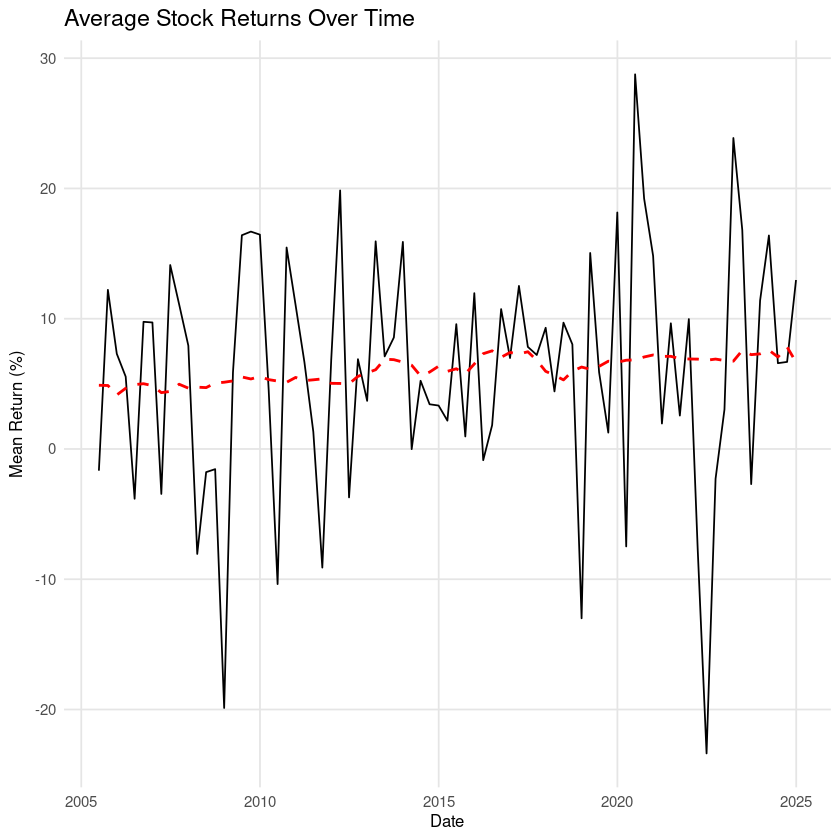

In [4]:
library(ggplot2)
library(dplyr)
library(zoo)

# Aggregate data: calculate mean return for each date
avg_returns <- panel_data_clean %>%
  group_by(date) %>%
  summarise(mean_return = mean(return_current, na.rm = TRUE)) %>%
  arrange(date) %>%
  mutate(trailing_mean = rollapply(mean_return, width = 36, FUN = mean, fill = c(NA, NA, NA), align = "center", partial = TRUE))

# Create the plot
ggplot(avg_returns, aes(x = date, y = mean_return)) +
  geom_line(color = "black", linewidth = 0.5) +
  geom_line(aes(y = trailing_mean), 
            color = "red", 
            linetype = "dashed", 
            linewidth = 0.8,
            na.rm = TRUE) +
  labs(
    title = "Average Stock Returns Over Time",
    x = "Date",
    y = "Mean Return (%)"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0, size = 14, face = "plain"),
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor = element_blank(),
    axis.title = element_text(size = 10),
    axis.text = element_text(size = 9)
  ) +
  scale_y_continuous(breaks = seq(-30, 30, by = 10))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-56.881  -3.269   5.094   6.162  13.890 106.071 

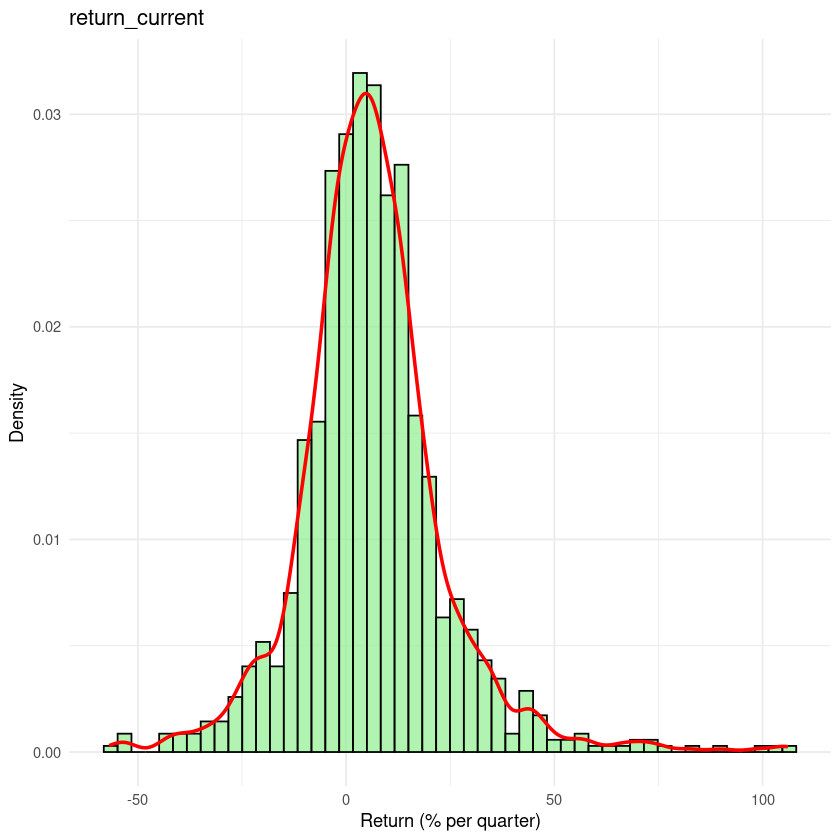

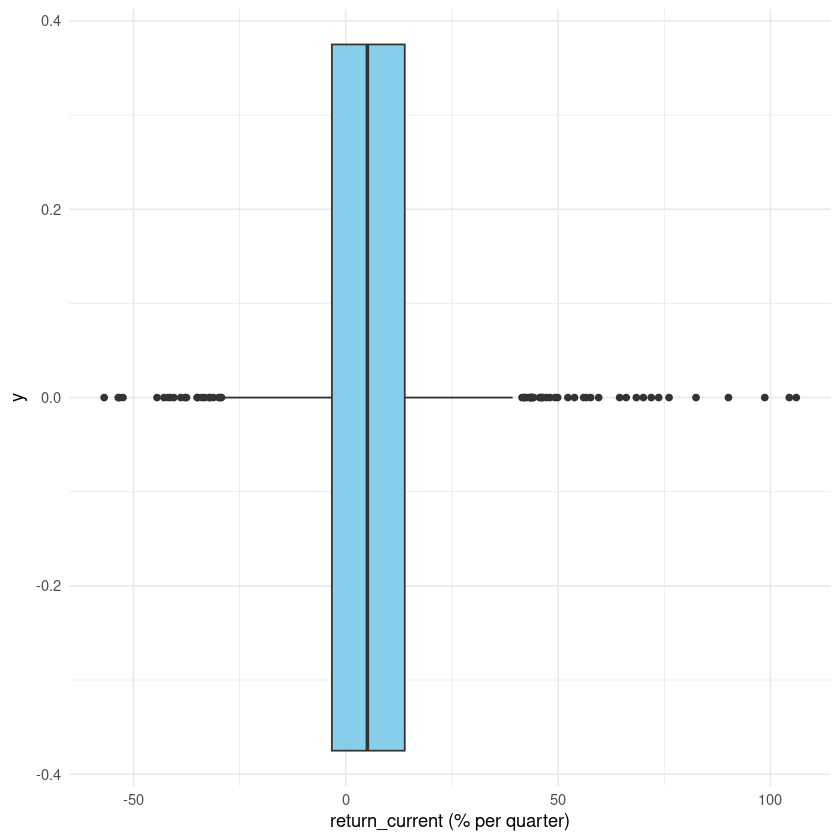

In [5]:
p5 <- ggplot(panel_data_clean, aes(x = return_current)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, fill = "lightgreen", color = "black", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1) +
  labs(title = "return_current",
       x = "Return (% per quarter)",
       y = "Density") +
  theme_minimal()

print(p5)

summary(panel_data_clean$return_current)
library(ggplot2)

# Create a boxplot of tooth length (len) by dose (dose)
ggplot(panel_data_clean, aes(x=return_current)) + 
  geom_boxplot(fill="skyblue") +
  labs(x = "return_current (% per quarter)", y = "y") +
  theme_minimal()

In [6]:
f <- lm(expected_return_current ~ lagged_return + lagged_volatility, data=panel_data_clean)
summary(f)

e <- lm(return_current ~ lagged_return + lagged_volatility, data=panel_data_clean)
summary(e)


Call:
lm(formula = expected_return_current ~ lagged_return + lagged_volatility, 
    data = panel_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.536  -1.181   0.102   1.419  46.192 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.35623    0.30364   4.467 8.81e-06 ***
lagged_return       0.07850    0.00857   9.160  < 2e-16 ***
lagged_volatility 202.67500   13.96898  14.509  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.857 on 1042 degrees of freedom
Multiple R-squared:  0.2214,	Adjusted R-squared:  0.2199 
F-statistic: 148.2 on 2 and 1042 DF,  p-value: < 2.2e-16



Call:
lm(formula = return_current ~ lagged_return + lagged_volatility, 
    data = panel_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-65.361  -8.355   0.439   8.510  81.564 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -1.08994    1.06237  -1.026  0.30515    
lagged_return       0.10827    0.02998   3.611  0.00032 ***
lagged_volatility 355.81102   48.87470   7.280 6.56e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.99 on 1042 degrees of freedom
Multiple R-squared:  0.05992,	Adjusted R-squared:  0.05811 
F-statistic: 33.21 on 2 and 1042 DF,  p-value: 1.046e-14



  99% CI BOOTSTRAP

FULL DATASET:
  Coefficient:  0.108266
  Std Error:    0.029984
  99% CI:       [0.031032, 0.185501]

Generating 100 bootstrap samples (non-winsorized)...

Capture rate (non-winsorized): 92.0% (92 out of 100 intervals)



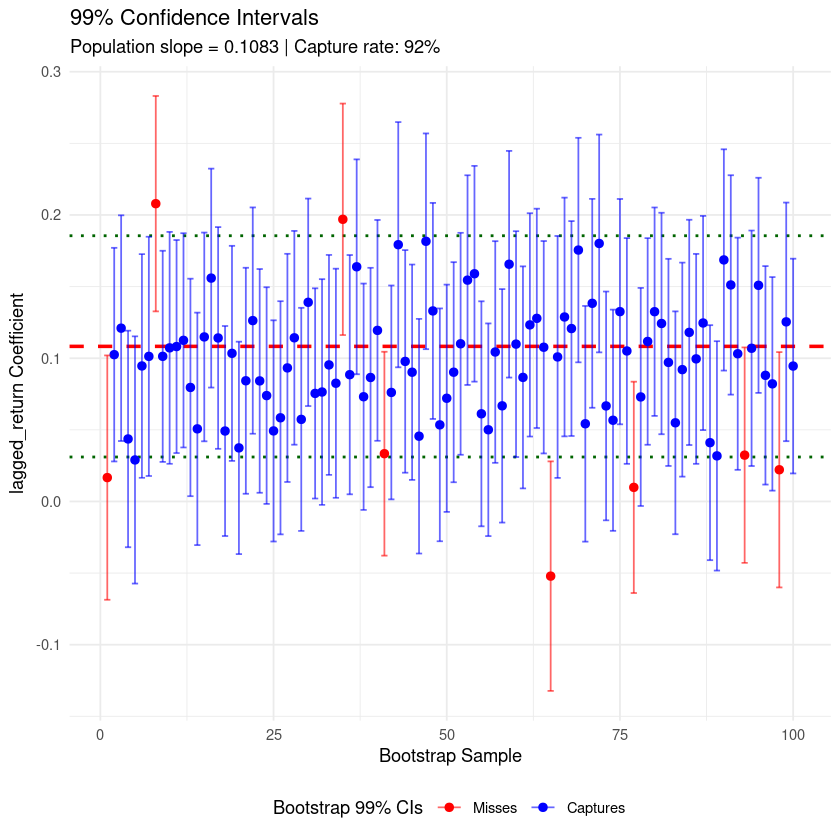

In [7]:
library(ggplot2)

# ============================================================================
# BOOTSTRAP CONFIDENCE INTERVALS - NON-WINSORIZED
# ============================================================================

cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  99% CI BOOTSTRAP\n")
cat("=", rep("=", 70), "\n\n", sep = "")

# Fit the main model (non-winsorized)
model_full <- lm(return_current ~ lagged_volatility + lagged_return,
                 data = panel_data_clean)

population_coef <- coef(model_full)["lagged_return"]
population_se <- summary(model_full)$coefficients["lagged_return", "Std. Error"]

# Calculate 99% CI for the full dataset
z_99 <- qnorm(0.995)
population_ci_lower <- population_coef - z_99 * population_se
population_ci_upper <- population_coef + z_99 * population_se

cat(sprintf("FULL DATASET:\n"))
cat(sprintf("  Coefficient:  %.6f\n", population_coef))
cat(sprintf("  Std Error:    %.6f\n", population_se))
cat(sprintf("  99%% CI:       [%.6f, %.6f]\n\n", population_ci_lower, population_ci_upper))

# Bootstrap samples
set.seed(123)
n_samples <- 100
bootstrap_results_orig <- data.frame()

cat("Generating", n_samples, "bootstrap samples (non-winsorized)...\n")

for(i in 1:n_samples) {
  sample_idx <- sample(1:nrow(panel_data_clean), replace = TRUE)
  boot_data <- panel_data_clean[sample_idx, ]
  
  boot_model <- tryCatch({
    lm(return_current ~ lagged_volatility + lagged_return, data = boot_data)
  }, error = function(e) NULL)
  
  if(!is.null(boot_model)) {
    coef_est <- coef(boot_model)["lagged_return"]
    se_est <- summary(boot_model)$coefficients["lagged_return", "Std. Error"]
    
    ci_lower <- coef_est - z_99 * se_est
    ci_upper <- coef_est + z_99 * se_est
    
    captures <- (ci_lower <= population_coef) & (ci_upper >= population_coef)
    
    bootstrap_results_orig <- rbind(bootstrap_results_orig, data.frame(
      sample = i,
      point_estimate = coef_est,
      ci_lower = ci_lower,
      ci_upper = ci_upper,
      captures = captures
    ))
  }
}

capture_rate_orig <- mean(bootstrap_results_orig$captures) * 100

cat(sprintf("\nCapture rate (non-winsorized): %.1f%% (%d out of %d intervals)\n\n", 
            capture_rate_orig, sum(bootstrap_results_orig$captures), nrow(bootstrap_results_orig)))

# Plot 1: Non-winsorized
plot1 <- ggplot(bootstrap_results_orig, aes(x = sample, y = point_estimate, color = captures)) +
  geom_hline(yintercept = population_ci_lower, color = "darkgreen", linewidth = 0.8, linetype = "dotted") +
  geom_hline(yintercept = population_ci_upper, color = "darkgreen", linewidth = 0.8, linetype = "dotted") +
  geom_hline(yintercept = population_coef, color = "red", linewidth = 1, linetype = "dashed") +
  geom_point(size = 2) +
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), alpha = 0.6, linewidth = 0.5) +
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue"),
                     labels = c("Misses", "Captures"),
                     name = "Bootstrap 99% CIs") +
  labs(title = "99% Confidence Intervals",
       subtitle = paste0("Population slope = ", round(population_coef, 4), 
                        " | Capture rate: ", round(capture_rate_orig, 1), "%"),
       x = "Bootstrap Sample",
       y = "lagged_return Coefficient") +
  theme_minimal(base_size = 11) +
  theme(legend.position = "bottom")

print(plot1)

In [8]:
suppressPackageStartupMessages({
  library(dplyr)
})

# ============================================
# DUAL MODEL OOS TESTING
# ============================================

cat(rep("=", 80), "\n", sep="")
cat("  OUT-OF-SAMPLE TEST: TWO MODELS\n")
cat(rep("=", 80), "\n\n", sep="")

# Sort by date
panel_data_clean <- panel_data_clean %>%
  arrange(date, stock_id)

# SPECIFY MODELS
model_formula <- "lagged_return + lagged_volatility"

cat("MODEL SPECIFICATIONS:\n")
cat("Model 1: return_current ~", model_formula, "\n")
cat("Model 2: expected_return_current ~", model_formula, "\n\n")

# ============================================
# OOS TESTING PARAMETERS
# ============================================

unique_dates <- sort(unique(panel_data_clean$date))
n_dates <- length(unique_dates)

min_train_periods <- 30  # Minimum training quarters
test_period <- 8         # Test window size
step_size <- 1           # Step between windows

cat("OOS TESTING PARAMETERS:\n")
cat("Training window: minimum", min_train_periods, "quarters (expanding window)\n")
cat("Test window:", test_period, "quarters\n")
cat("Step size:", step_size, "quarters\n")
cat("Window type: EXPANDING (training always starts from beginning)\n\n")

cat(rep("=", 80), "\n", sep="")
cat("RUNNING OOS TEST...\n\n")

# Storage for results
window_results_return <- data.frame()
window_results_expected <- data.frame()

# EXPANDING WINDOW: training always starts from beginning
train_start_idx <- 1
train_end_idx <- min_train_periods

iteration <- 0

while(train_end_idx + test_period <= n_dates) {
  iteration <- iteration + 1
  
  # Define train and test periods
  train_dates <- unique_dates[train_start_idx:train_end_idx]
  test_start_idx <- train_end_idx + 1
  test_end_idx <- min(test_start_idx + test_period - 1, n_dates)
  test_dates <- unique_dates[test_start_idx:test_end_idx]
  
  train_data <- panel_data_clean %>% filter(date %in% train_dates)
  test_data <- panel_data_clean %>% filter(date %in% test_dates)
  
  if(nrow(test_data) < 50) {
    cat(sprintf("Window %d: SKIPPED (insufficient test data)\n\n", iteration))
    train_end_idx <- train_end_idx + step_size
    next
  }
  
  cat(sprintf("Window %d: Train [%s to %s] → Test [%s to %s]\n", 
              iteration,
              format(min(train_dates), "%Y-%m-%d"),
              format(max(train_dates), "%Y-%m-%d"),
              format(min(test_dates), "%Y-%m-%d"),
              format(max(test_dates), "%Y-%m-%d")))
  
  # ========================================
  # MODEL 1: PREDICT return_current
  # ========================================
  tryCatch({
    full_formula <- as.formula(paste("return_current ~", model_formula))
    model <- lm(full_formula, data = train_data)
    
    in_sample_r2 <- summary(model)$r.squared
    in_sample_adj_r2 <- summary(model)$adj.r.squared
    
    pred <- predict(model, newdata = test_data)
    
    if(!any(is.na(pred)) && !any(is.infinite(pred))) {
      ss_res <- sum((test_data$return_current - pred)^2)
      ss_tot <- sum((test_data$return_current - mean(test_data$return_current))^2)
      oos_r2 <- 1 - (ss_res / ss_tot)
      
      rmse <- sqrt(mean((test_data$return_current - pred)^2))
      mae <- mean(abs(test_data$return_current - pred))
      correlation <- cor(test_data$return_current, pred)
      
      window_results_return <- rbind(window_results_return, data.frame(
        window = iteration,
        train_start_date = min(train_dates),
        train_end_date = max(train_dates),
        test_start_date = min(test_dates),
        test_end_date = max(test_dates),
        n_train = nrow(train_data),
        n_test = nrow(test_data),
        in_sample_r2 = in_sample_r2,
        in_sample_adj_r2 = in_sample_adj_r2,
        oos_r2 = oos_r2,
        rmse = rmse,
        mae = mae,
        correlation = correlation
      ))
      
      cat(sprintf("  return_current:          IS R²=%.4f | OOS R²=%.4f | RMSE=%.4f\n", 
                  in_sample_r2, oos_r2, rmse))
    }
  }, error = function(e) {
    cat(sprintf("  return_current:  ERROR - %s\n", e$message))
  })
  
  # ========================================
  # MODEL 2: PREDICT expected_return_current (FIXED!)
  # ========================================
  tryCatch({
    full_formula <- as.formula(paste("expected_return_current ~", model_formula))
    model <- lm(full_formula, data = train_data)
    
    in_sample_r2 <- summary(model)$r.squared
    in_sample_adj_r2 <- summary(model)$adj.r.squared
    
    pred <- predict(model, newdata = test_data)
    
    if(!any(is.na(pred)) && !any(is.infinite(pred))) {
      # FIXED: Changed from expected_return to expected_return_current
      ss_res <- sum((test_data$expected_return_current - pred)^2)
      ss_tot <- sum((test_data$expected_return_current - mean(test_data$expected_return_current))^2)
      oos_r2 <- 1 - (ss_res / ss_tot)
      
      rmse <- sqrt(mean((test_data$expected_return_current - pred)^2))
      mae <- mean(abs(test_data$expected_return_current - pred))
      # FIXED: Changed from expected_return to expected_return_current
      correlation <- cor(test_data$expected_return_current, pred)
      
      window_results_expected <- rbind(window_results_expected, data.frame(
        window = iteration,
        train_start_date = min(train_dates),
        train_end_date = max(train_dates),
        test_start_date = min(test_dates),
        test_end_date = max(test_dates),
        n_train = nrow(train_data),
        n_test = nrow(test_data),
        in_sample_r2 = in_sample_r2,
        in_sample_adj_r2 = in_sample_adj_r2,
        oos_r2 = oos_r2,
        rmse = rmse,
        mae = mae,
        correlation = correlation
      ))
      
      cat(sprintf("  expected_return_current: IS R²=%.4f | OOS R²=%.4f | RMSE=%.4f\n", 
                  in_sample_r2, oos_r2, rmse))
    }
  }, error = function(e) {
    cat(sprintf("  expected_return_current:  ERROR - %s\n", e$message))
  })
  
  cat("\n")
  
  # EXPANDING WINDOW: only move end forward
  train_end_idx <- train_end_idx + step_size
}

# ============================================
# RESULTS SUMMARY
# ============================================

cat(rep("=", 80), "\n", sep="")
cat("RESULTS SUMMARY\n")
cat(rep("=", 80), "\n\n", sep="")

# ========================================
# MODEL 1: return_current
# ========================================

cat("MODEL 1: PREDICTING return_current\n")
cat(rep("-", 80), "\n", sep="")

if(nrow(window_results_return) > 0) {
  
  cat(sprintf("Number of test windows: %d\n\n", nrow(window_results_return)))
  
  cat("IN-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_return$in_sample_r2), mean(window_results_return$in_sample_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_return$in_sample_r2), median(window_results_return$in_sample_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_return$in_sample_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n\n", min(window_results_return$in_sample_r2), max(window_results_return$in_sample_r2)))
  
  cat("OUT-OF-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_return$oos_r2), mean(window_results_return$oos_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_return$oos_r2), median(window_results_return$oos_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_return$oos_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n", min(window_results_return$oos_r2), max(window_results_return$oos_r2)))
  cat(sprintf("  Positive windows: %d/%d (%.0f%%)\n\n", 
              sum(window_results_return$oos_r2 > 0), nrow(window_results_return),
              mean(window_results_return$oos_r2 > 0)*100))
  
  cat("OTHER METRICS:\n")
  cat(sprintf("  Mean RMSE:        %.4f\n", mean(window_results_return$rmse)))
  cat(sprintf("  Mean MAE:         %.4f\n", mean(window_results_return$mae)))
  cat(sprintf("  Mean Correlation: %.4f\n\n", mean(window_results_return$correlation)))
  
  cat("DEGRADATION ANALYSIS:\n")
  degradation <- mean(window_results_return$in_sample_r2) - mean(window_results_return$oos_r2)
  degradation_pct <- (degradation / mean(window_results_return$in_sample_r2)) * 100
  cat(sprintf("  Mean in-sample R²:     %.4f (%.2f%%)\n", 
              mean(window_results_return$in_sample_r2), mean(window_results_return$in_sample_r2)*100))
  cat(sprintf("  Mean out-of-sample R²: %.4f (%.2f%%)\n", 
              mean(window_results_return$oos_r2), mean(window_results_return$oos_r2)*100))
  cat(sprintf("  Degradation:           %.4f (%.1f%% drop)\n\n", 
              degradation, degradation_pct))
  
} else {
  cat("NO VALID RESULTS OBTAINED\n\n")
}

# ========================================
# MODEL 2: expected_return_current
# ========================================

cat(rep("=", 80), "\n", sep="")
cat("MODEL 2: PREDICTING expected_return_current\n")
cat(rep("-", 80), "\n", sep="")

if(nrow(window_results_expected) > 0) {
  
  cat(sprintf("Number of test windows: %d\n\n", nrow(window_results_expected)))
  
  cat("IN-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_expected$in_sample_r2), mean(window_results_expected$in_sample_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_expected$in_sample_r2), median(window_results_expected$in_sample_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_expected$in_sample_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n\n", min(window_results_expected$in_sample_r2), max(window_results_expected$in_sample_r2)))
  
  cat("OUT-OF-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_expected$oos_r2), mean(window_results_expected$oos_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_expected$oos_r2), median(window_results_expected$oos_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_expected$oos_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n", min(window_results_expected$oos_r2), max(window_results_expected$oos_r2)))
  cat(sprintf("  Positive windows: %d/%d (%.0f%%)\n\n", 
              sum(window_results_expected$oos_r2 > 0), nrow(window_results_expected),
              mean(window_results_expected$oos_r2 > 0)*100))
  
  cat("OTHER METRICS:\n")
  cat(sprintf("  Mean RMSE:        %.4f\n", mean(window_results_expected$rmse)))
  cat(sprintf("  Mean MAE:         %.4f\n", mean(window_results_expected$mae)))
  cat(sprintf("  Mean Correlation: %.4f\n\n", mean(window_results_expected$correlation)))
  
  cat("DEGRADATION ANALYSIS:\n")
  degradation <- mean(window_results_expected$in_sample_r2) - mean(window_results_expected$oos_r2)
  degradation_pct <- (degradation / mean(window_results_expected$in_sample_r2)) * 100
  cat(sprintf("  Mean in-sample R²:     %.4f (%.2f%%)\n", 
              mean(window_results_expected$in_sample_r2), mean(window_results_expected$in_sample_r2)*100))
  cat(sprintf("  Mean out-of-sample R²: %.4f (%.2f%%)\n", 
              mean(window_results_expected$oos_r2), mean(window_results_expected$oos_r2)*100))
  cat(sprintf("  Degradation:           %.4f (%.1f%% drop)\n\n", 
              degradation, degradation_pct))
  
} else {
  cat("NO VALID RESULTS OBTAINED\n\n")
}

# ========================================
# COMPARISON
# ========================================

if(nrow(window_results_return) > 0 && nrow(window_results_expected) > 0) {
  
  cat(rep("=", 80), "\n", sep="")
  cat("COMPARISON: return_current vs expected_return_current\n")
  cat(rep("=", 80), "\n\n", sep="")
  
  cat(sprintf("%-25s | %18s | %18s\n", "Metric", "return_current", "expected_return"))
  cat(rep("-", 70), "\n", sep="")
  cat(sprintf("%-25s | %18.4f | %18.4f\n", "Mean In-Sample R²", 
              mean(window_results_return$in_sample_r2), 
              mean(window_results_expected$in_sample_r2)))
  cat(sprintf("%-25s | %18.4f | %18.4f\n", "Mean OOS R²", 
              mean(window_results_return$oos_r2), 
              mean(window_results_expected$oos_r2)))
  cat(sprintf("%-25s | %18.4f | %18.4f\n", "Median OOS R²", 
              median(window_results_return$oos_r2), 
              median(window_results_expected$oos_r2)))
  cat(sprintf("%-25s | %18.4f | %18.4f\n", "SD OOS R²", 
              sd(window_results_return$oos_r2), 
              sd(window_results_expected$oos_r2)))
  cat(sprintf("%-25s | %18.4f | %18.4f\n", "Mean RMSE", 
              mean(window_results_return$rmse), 
              mean(window_results_expected$rmse)))
  cat(sprintf("%-25s | %18.4f | %18.4f\n", "Mean Correlation", 
              mean(window_results_return$correlation), 
              mean(window_results_expected$correlation)))
  cat(sprintf("%-25s | %17.1f%% | %17.1f%%\n", "%% Positive OOS", 
              mean(window_results_return$oos_r2 > 0)*100, 
              mean(window_results_expected$oos_r2 > 0)*100))
  cat("\n")
  
  # Determine which is better
  if(mean(window_results_return$oos_r2) > mean(window_results_expected$oos_r2)) {
    diff <- mean(window_results_return$oos_r2) - mean(window_results_expected$oos_r2)
    cat(sprintf("CONCLUSION: return_current has %.4f higher mean OOS R²\n", diff))
  } else {
    diff <- mean(window_results_expected$oos_r2) - mean(window_results_return$oos_r2)
    cat(sprintf("CONCLUSION: expected_return_current has %.4f higher mean OOS R²\n", diff))
  }
}

cat("\n", rep("=", 80), "\n", sep="")
cat("ANALYSIS COMPLETE!\n")
cat(rep("=", 80), "\n", sep="")

  OUT-OF-SAMPLE TEST: TWO MODELS

MODEL SPECIFICATIONS:
Model 1: return_current ~ lagged_return + lagged_volatility 
Model 2: expected_return_current ~ lagged_return + lagged_volatility 

OOS TESTING PARAMETERS:
Training window: minimum 30 quarters (expanding window)
Test window: 8 quarters
Step size: 1 quarters
Window type: EXPANDING (training always starts from beginning)

RUNNING OOS TEST...

Window 1: Train [2005-06-30 to 2012-09-28] → Test [2012-12-31 to 2014-09-30]
  return_current:          IS R²=0.0135 | OOS R²=0.0343 | RMSE=14.7635
  expected_return_current: IS R²=0.0883 | OOS R²=0.5280 | RMSE=1.9948

Window 2: Train [2005-06-30 to 2012-12-31] → Test [2013-03-28 to 2014-12-31]
  return_current:          IS R²=0.0184 | OOS R²=0.0014 | RMSE=13.7298
  expected_return_current: IS R²=0.0875 | OOS R²=0.5692 | RMSE=1.9560

Window 3: Train [2005-06-30 to 2013-03-28] → Test [2013-06-28 to 2015-03-31]
  return_current:          IS R²=0.0283 | OOS R²=-0.0254 | RMSE=10.5174
  expected_ret

In [9]:
model_vol_only <- lm(expected_return_current ~ lagged_volatility, 
                     data = panel_data_clean)
r2_vol_only <- summary(model_vol_only)$r.squared

# Model 2: Both lagged_return and lagged_volatility
model_both <- lm(expected_return_current ~ lagged_return + lagged_volatility, 
                 data = panel_data_clean)
r2_both <- summary(model_both)$r.squared

# Model 3: Just lagged_return (for comparison)
model_return_only <- lm(expected_return_current ~ lagged_return, 
                        data = panel_data_clean)
r2_return_only <- summary(model_return_only)$r.squared

# Calculate incremental R²
delta_r2_return <- r2_both - r2_vol_only
delta_r2_vol <- r2_both - r2_return_only

# Display results
cat("\n=== INCREMENTAL R² ANALYSIS ===\n\n")
cat(sprintf("Model with lagged_volatility only:  R² = %.4f (%.2f%%)\n", 
            r2_vol_only, r2_vol_only*100))
cat(sprintf("Model with lagged_return only:      R² = %.4f (%.2f%%)\n", 
            r2_return_only, r2_return_only*100))
cat(sprintf("Model with BOTH:                    R² = %.4f (%.2f%%)\n\n", 
            r2_both, r2_both*100))

cat(sprintf("Incremental R² from adding lagged_return:     %.4f (%.2f%% points)\n", 
            delta_r2_return, delta_r2_return*100))
cat(sprintf("Incremental R² from adding lagged_volatility: %.4f (%.2f%% points)\n\n", 
            delta_r2_vol, delta_r2_vol*100))

# Interpretation
if(delta_r2_return > 0.05) {
  cat("lagged_return adds MEANINGFUL predictive power (>5% R² increase)\n")
} else {
  cat("lagged_return adds WEAK predictive power (<5% R² increase)\n")
}

# F-test for significance of lagged_return
anova_result <- anova(model_vol_only, model_both)
cat(sprintf("\nF-test p-value: %.6f\n", anova_result$`Pr(>F)`[2]))

if(anova_result$`Pr(>F)`[2] < 0.05) {
  cat("lagged_return is statistically significant (p < 0.05)\n")
} else {
  cat("lagged_return is NOT statistically significant\n")
}


=== INCREMENTAL R² ANALYSIS ===

Model with lagged_volatility only:  R² = 0.1587 (15.87%)
Model with lagged_return only:      R² = 0.0641 (6.41%)
Model with BOTH:                    R² = 0.2214 (22.14%)

Incremental R² from adding lagged_return:     0.0627 (6.27% points)
Incremental R² from adding lagged_volatility: 0.1573 (15.73% points)

lagged_return adds MEANINGFUL predictive power (>5% R² increase)

F-test p-value: 0.000000
lagged_return is statistically significant (p < 0.05)


In [12]:
cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  CORRELATION: lagged_volatility vs lagged_return\n")
cat("=", rep("=", 70), "\n\n", sep = "")

winsorize <- function(x, probs = c(0.01, 0.99)) {
  quantiles <- quantile(x, probs = probs, na.rm = TRUE)
  x[x < quantiles[1]] <- quantiles[1]
  x[x > quantiles[2]] <- quantiles[2]
  return(x)
}

panel_data_clean <- panel_data_clean %>%
  mutate(
    return_current_wins = winsorize(return_current, probs = c(0.01, 0.99)),
    expected_return_current_wins = winsorize(expected_return_current, probs = c(0.01, 0.99)),
    lagged_return_wins = winsorize(lagged_return, probs = c(0.01, 0.99)),
    lagged_volatility_wins = winsorize(lagged_volatility, probs = c(0.01, 0.99))
  )


# ORIGINAL VARIABLES
cor_original <- cor(panel_data_clean$lagged_volatility, 
                    panel_data_clean$lagged_return, 
                    use = "complete.obs")

cat("ORIGINAL VARIABLES:\n")
cat("  Correlation (r): ", round(cor_original, 4), "\n\n", sep = "")

# WINSORIZED VARIABLES
cor_wins <- cor(panel_data_clean$lagged_volatility_wins, 
                panel_data_clean$lagged_return_wins, 
                use = "complete.obs")

cat("WINSORIZED VARIABLES:\n")
cat("  Correlation (r): ", round(cor_wins, 4), "\n\n", sep = "")

cat("=", rep("=", 70), "\n", sep = "")
cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  VARIANCE INFLATION FACTOR (VIF) TEST\n")
cat("=", rep("=", 70), "\n\n", sep = "")

# ORIGINAL VARIABLES
model_vol_orig <- lm(lagged_volatility ~ lagged_return, data = panel_data_clean)
vif_vol_orig <- 1 / (1 - summary(model_vol_orig)$r.squared)

model_ret_orig <- lm(lagged_return ~ lagged_volatility, data = panel_data_clean)
vif_ret_orig <- 1 / (1 - summary(model_ret_orig)$r.squared)

cat("ORIGINAL VARIABLES:\n")
cat("  VIF (lagged_volatility): ", round(vif_vol_orig, 4), "\n", sep = "")
cat("  VIF (lagged_return):     ", round(vif_ret_orig, 4), "\n", sep = "")
if(max(vif_vol_orig, vif_ret_orig) < 5) {
  cat("  VIF < 5: No multicollinearity\n\n")
} else if(max(vif_vol_orig, vif_ret_orig) < 10) {
  cat("  VIF 5-10: Moderate multicollinearity\n\n")
} else {
  cat("  VIF > 10: Severe multicollinearity\n\n")
}

# WINSORIZED VARIABLES
model_vol_wins <- lm(lagged_volatility_wins ~ lagged_return_wins, data = panel_data_clean)
vif_vol_wins <- 1 / (1 - summary(model_vol_wins)$r.squared)

model_ret_wins <- lm(lagged_return_wins ~ lagged_volatility_wins, data = panel_data_clean)
vif_ret_wins <- 1 / (1 - summary(model_ret_wins)$r.squared)

cat("WINSORIZED VARIABLES:\n")
cat("VIF (lagged_volatility_wins):", round(vif_vol_wins, 4), "\n", sep = "")
cat("VIF (lagged_return_wins):", round(vif_ret_wins, 4), "\n", sep = "")

# ============================================================================
# SKEWNESS CALCULATION
# ============================================================================

cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  SKEWNESS ANALYSIS\n")
cat("=", rep("=", 70), "\n\n", sep = "")

# Manual skewness calculation (no extra packages needed)
skewness <- function(x) {
  x <- x[!is.na(x)]
  n <- length(x)
  mean_x <- mean(x)
  sd_x <- sd(x)
  skew <- (sum((x - mean_x)^3) / n) / (sd_x^3)
  return(skew)
}

# ORIGINAL VARIABLES
skew_vol_orig <- skewness(panel_data_clean$lagged_volatility)
skew_ret_orig <- skewness(panel_data_clean$lagged_return)

cat("ORIGINAL VARIABLES:\n")
cat("  lagged_volatility skewness: ", round(skew_vol_orig, 4), "\n", sep = "")
cat("  lagged_return skewness:     ", round(skew_ret_orig, 4), "\n", sep = "")

if(abs(skew_vol_orig) < 0.5) {
  cat("  lagged_volatility: Approximately symmetric\n")
} else if(skew_vol_orig > 0.5) {
  cat("  lagged_volatility: Right-skewed (long right tail)\n")
} else {
  cat("  lagged_volatility: Left-skewed (long left tail)\n")
}

if(abs(skew_ret_orig) < 0.5) {
  cat("  lagged_return: Approximately symmetric\n")
} else if(skew_ret_orig > 0.5) {
  cat("  lagged_return: Right-skewed (long right tail)\n")
} else {
  cat("  lagged_return: Left-skewed (long left tail)\n")
}

cat("\n")

cat("\n")
cat("INTERPRETATION:\n")
cat("  Skewness = 0:  Perfectly symmetric (normal distribution)\n")
cat("  Skewness > 0:  Right-skewed (tail extends to the right)\n")
cat("  Skewness < 0:  Left-skewed (tail extends to the left)\n")
cat("  |Skewness| < 0.5:  Approximately symmetric\n")
cat("  |Skewness| > 1:    Highly skewed\n")

cat("\n")
cat("=", rep("=", 70), "\n", sep = "")


  CORRELATION: lagged_volatility vs lagged_return

ORIGINAL VARIABLES:
  Correlation (r): 0.0071

WINSORIZED VARIABLES:
  Correlation (r): -0.0067


  VARIANCE INFLATION FACTOR (VIF) TEST

ORIGINAL VARIABLES:
  VIF (lagged_volatility): 1.0001
  VIF (lagged_return):     1.0001
  VIF < 5: No multicollinearity

WINSORIZED VARIABLES:
VIF (lagged_volatility_wins):1
VIF (lagged_return_wins):1

  SKEWNESS ANALYSIS

ORIGINAL VARIABLES:
  lagged_volatility skewness: 1.7221
  lagged_return skewness:     0.8552
  lagged_volatility: Right-skewed (long right tail)
  lagged_return: Right-skewed (long right tail)


INTERPRETATION:
  Skewness = 0:  Perfectly symmetric (normal distribution)
  Skewness > 0:  Right-skewed (tail extends to the right)
  Skewness < 0:  Left-skewed (tail extends to the left)
  |Skewness| < 0.5:  Approximately symmetric
  |Skewness| > 1:    Highly skewed



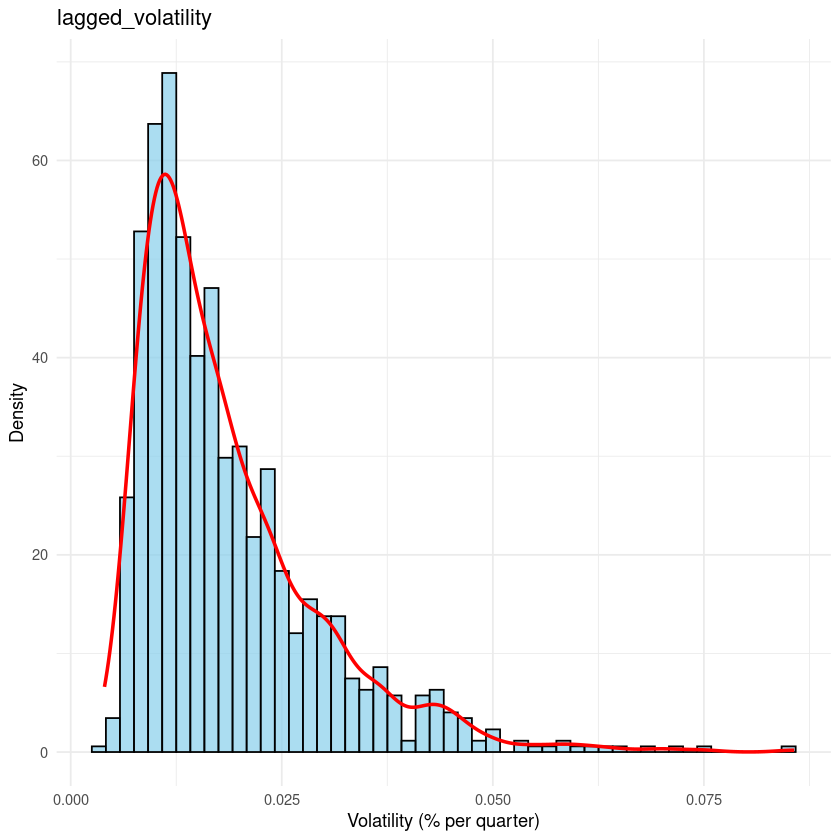

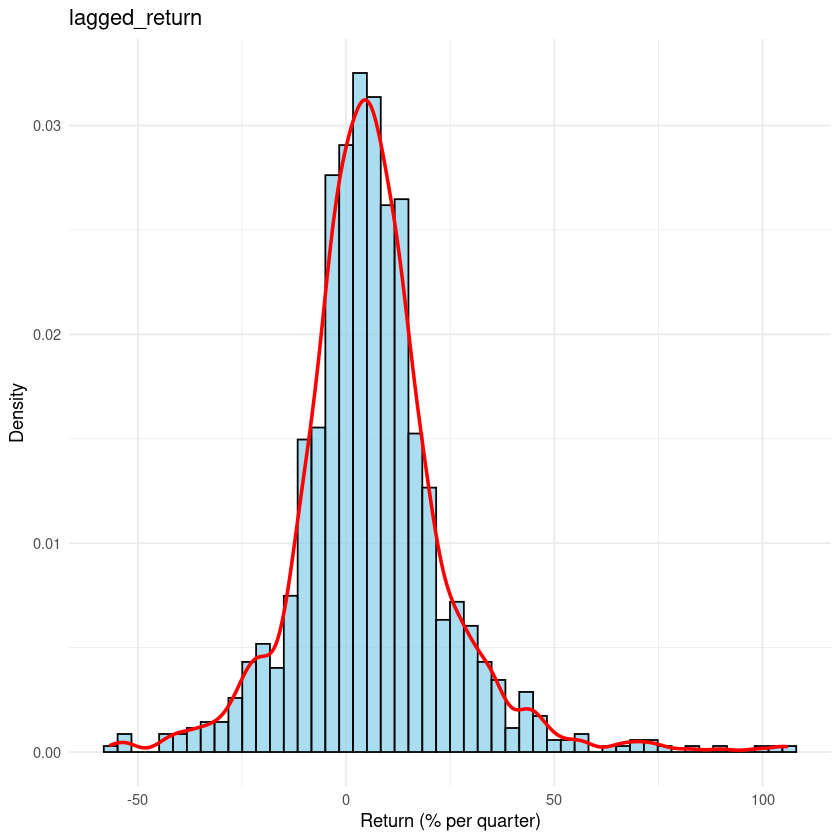

In [13]:
p1 <- ggplot(panel_data_clean, aes(x = lagged_volatility)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, fill = "skyblue", color = "black", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1) +
  labs(title = "lagged_volatility",
       x = "Volatility (% per quarter)",
       y = "Density") +
  theme_minimal()

# Plot 3: lagged_return (original)
p3 <- ggplot(panel_data_clean, aes(x = lagged_return)) +
  geom_histogram(aes(y = after_stat(density)), bins = 50, fill = "skyblue", color = "black", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1) +
  labs(title = "lagged_return",
       x = "Return (% per quarter)",
       y = "Density") +
  theme_minimal()

# Display plots
print(p1)

print(p3)



  OLS GAUSS-MARKOV ASSUMPTION CHECKS

1. LINEARITY & ZERO CONDITIONAL MEAN
   ---------------------------------
   Mean of residuals: 0
   Should be: approximately 0


   Press Enter to continue...

 enter



2. HOMOSCEDASTICITY (Constant Variance)
   -------------------------------------


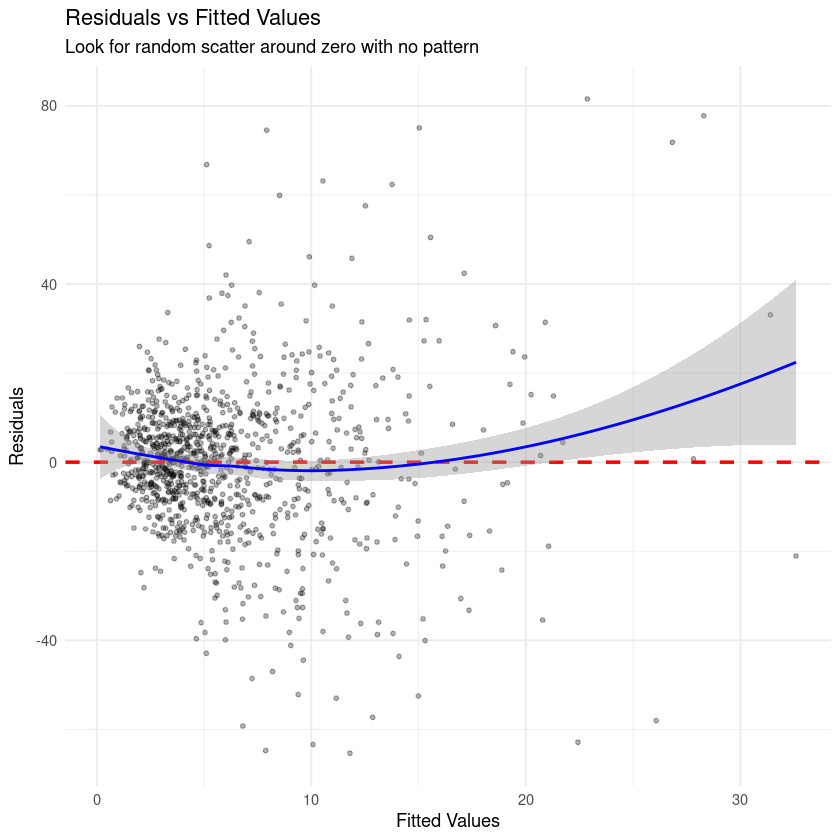


   Press Enter to continue...

 enter



3. NORMALITY OF RESIDUALS
   ----------------------


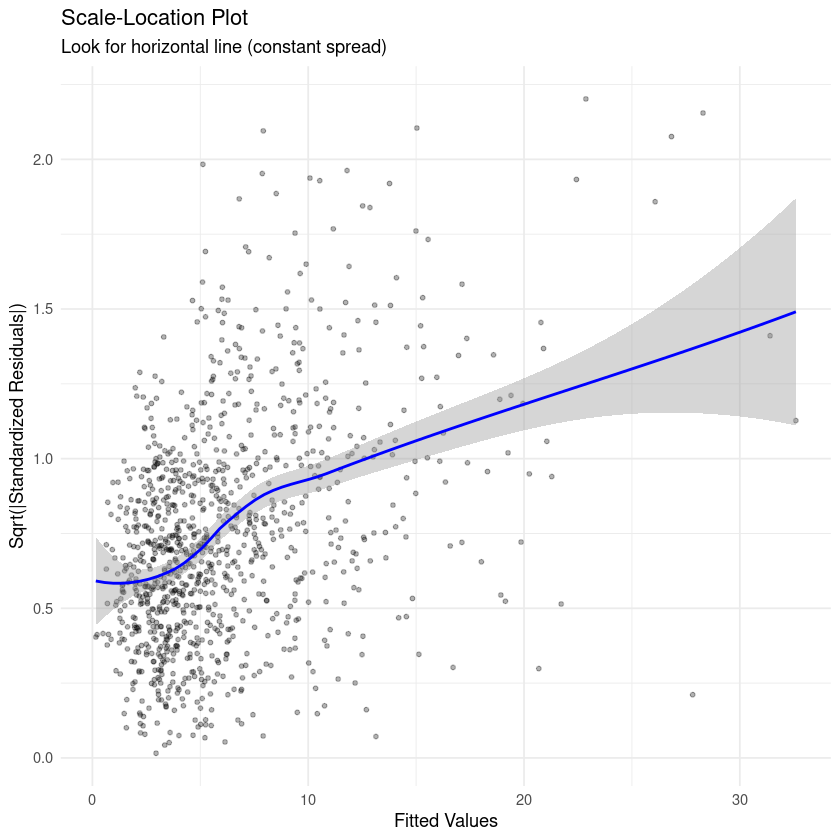


   Press Enter to continue...

 enter\


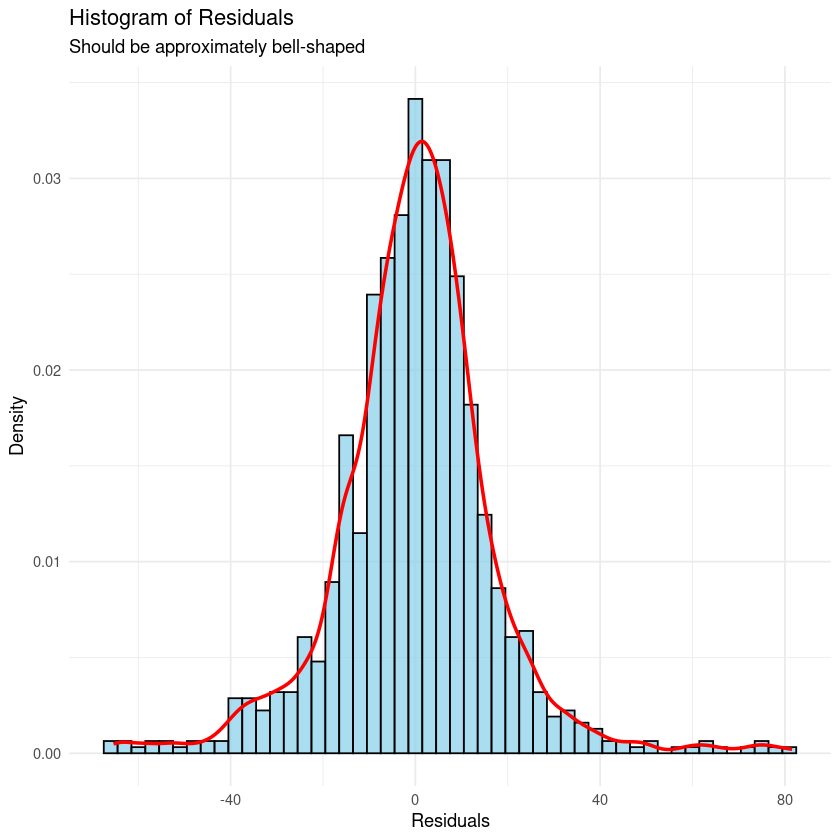


   Shapiro-Wilk Test:
   p-value = 1.492259e-18
   REJECT normality (p < 0.05)

   Press Enter to continue...

 enter



4. AUTOCORRELATION
   ---------------
   Durbin-Watson Statistic: 1.6166
   Interpretation:
     - DW close to 2.0 = No autocorrelation
     - DW < 2.0 = Positive autocorrelation
     - DW > 2.0 = Negative autocorrelation


5. INFLUENTIAL OBSERVATIONS
   ------------------------


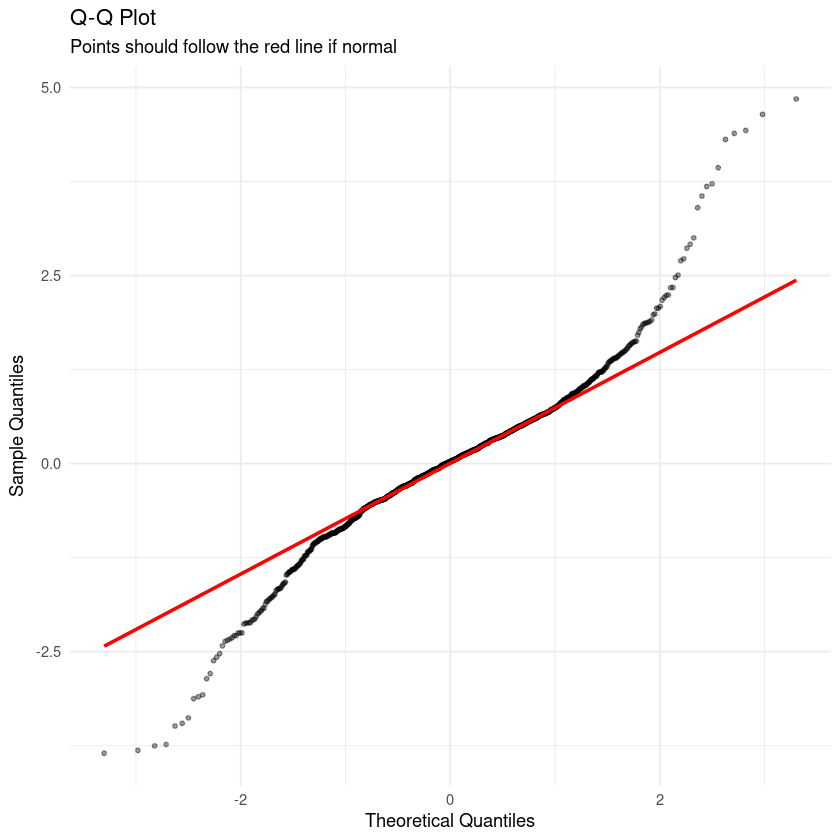


   Influential points (Cook's D > 4/n): 78 (7.46%)

  DIAGNOSTICS COMPLETE



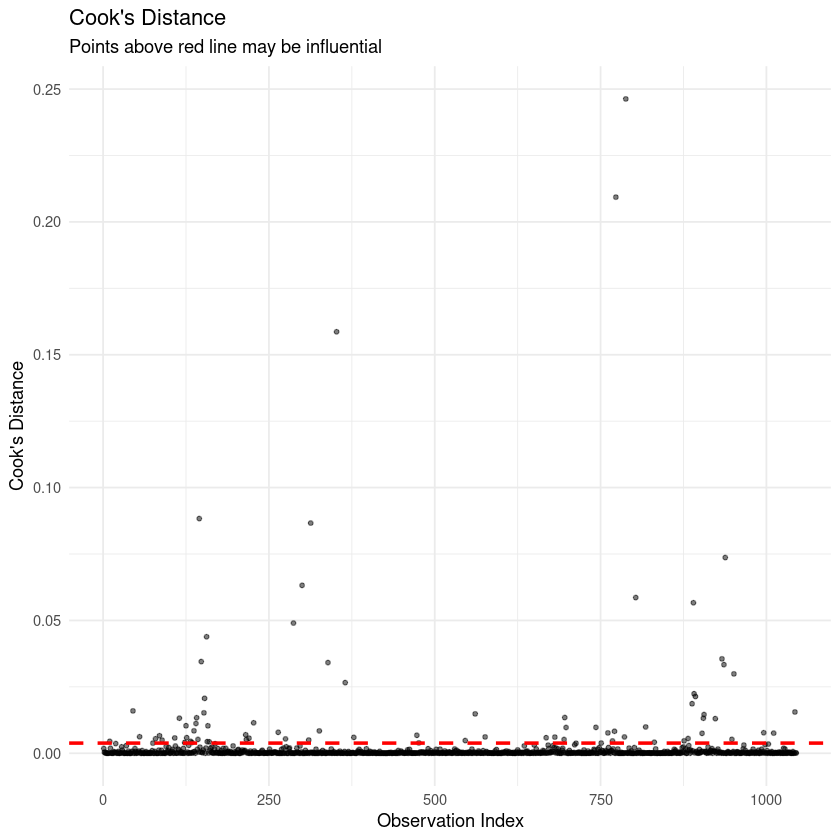

In [14]:
library(ggplot2)

# Fit your model
model1 <- lm(return_current ~ lagged_volatility + lagged_return,
             data = panel_data_clean)

# Extract residuals and fitted values
resids <- residuals(model1)
fitted_vals <- fitted(model1)
std_resids <- rstandard(model1)

cat("\n")
cat("=" , rep("=", 60), "\n", sep = "")
cat("  OLS GAUSS-MARKOV ASSUMPTION CHECKS\n")
cat("=" , rep("=", 60), "\n\n", sep = "")

# ============================================
# 1. LINEARITY & ZERO CONDITIONAL MEAN
# ============================================
cat("1. LINEARITY & ZERO CONDITIONAL MEAN\n")
cat("   ---------------------------------\n")
cat("   Mean of residuals: ", round(mean(resids), 10), "\n", sep = "")
cat("   Should be: approximately 0\n\n")

plot1 <- ggplot(data.frame(fitted = fitted_vals, resids = resids), 
                aes(x = fitted, y = resids)) +
  geom_point(alpha = 0.3, size = 1) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed", linewidth = 1) +
  geom_smooth(method = "loess", formula = y ~ x, se = TRUE, color = "blue", linewidth = 0.8) +
  labs(title = "Residuals vs Fitted Values",
       subtitle = "Look for random scatter around zero with no pattern",
       x = "Fitted Values",
       y = "Residuals") +
  theme_minimal(base_size = 11)

print(plot1)
cat("\n   Press Enter to continue...")
readline()

# ============================================
# 2. HOMOSCEDASTICITY
# ============================================
cat("\n2. HOMOSCEDASTICITY (Constant Variance)\n")
cat("   -------------------------------------\n")

plot2 <- ggplot(data.frame(fitted = fitted_vals, 
                           sqrt_std_resids = sqrt(abs(std_resids))), 
                aes(x = fitted, y = sqrt_std_resids)) +
  geom_point(alpha = 0.3, size = 1) +
  geom_smooth(method = "loess", formula = y ~ x, se = TRUE, color = "blue", linewidth = 0.8) +
  labs(title = "Scale-Location Plot",
       subtitle = "Look for horizontal line (constant spread)",
       x = "Fitted Values",
       y = "Sqrt(|Standardized Residuals|)") +
  theme_minimal(base_size = 11)

print(plot2)
cat("\n   Press Enter to continue...")
readline()

# ============================================
# 3. NORMALITY OF RESIDUALS
# ============================================
cat("\n3. NORMALITY OF RESIDUALS\n")
cat("   ----------------------\n")

plot3 <- ggplot(data.frame(resids = resids), aes(x = resids)) +
  geom_histogram(aes(y = after_stat(density)), 
                 bins = 50, fill = "skyblue", color = "black", alpha = 0.7) +
  geom_density(color = "red", linewidth = 1) +
  labs(title = "Histogram of Residuals",
       subtitle = "Should be approximately bell-shaped",
       x = "Residuals",
       y = "Density") +
  theme_minimal(base_size = 11)

print(plot3)
cat("\n   Press Enter to continue...")
readline()

plot4 <- ggplot(data.frame(std_resids = std_resids), aes(sample = std_resids)) +
  stat_qq(alpha = 0.4, size = 1) +
  stat_qq_line(color = "red", linewidth = 1) +
  labs(title = "Q-Q Plot",
       subtitle = "Points should follow the red line if normal",
       x = "Theoretical Quantiles",
       y = "Sample Quantiles") +
  theme_minimal(base_size = 11)

print(plot4)

# Shapiro test
if(length(resids) > 5000) {
  sample_idx <- sample(1:length(resids), 5000)
  sw_test <- shapiro.test(resids[sample_idx])
  cat("\n   Shapiro-Wilk Test (5000 sample):\n")
} else {
  sw_test <- shapiro.test(resids)
  cat("\n   Shapiro-Wilk Test:\n")
}
cat("   p-value = ", format(sw_test$p.value, scientific = TRUE), "\n", sep = "")
cat("   ", ifelse(sw_test$p.value < 0.05, 
                  "REJECT normality (p < 0.05)",
                  "Normality assumption OK (p >= 0.05)"), "\n", sep = "")

cat("\n   Press Enter to continue...")
readline()

# ============================================
# 4. NO AUTOCORRELATION
# ============================================
cat("\n4. AUTOCORRELATION\n")
cat("   ---------------\n")
dw_stat <- sum(diff(resids)^2) / sum(resids^2)
cat("   Durbin-Watson Statistic: ", round(dw_stat, 4), "\n", sep = "")
cat("   Interpretation:\n")
cat("     - DW close to 2.0 = No autocorrelation\n")
cat("     - DW < 2.0 = Positive autocorrelation\n")
cat("     - DW > 2.0 = Negative autocorrelation\n\n")

# ============================================
# 5. INFLUENTIAL OBSERVATIONS
# ============================================
cat("\n5. INFLUENTIAL OBSERVATIONS\n")
cat("   ------------------------\n")
cooks <- cooks.distance(model1)
threshold <- 4/length(resids)

plot5 <- ggplot(data.frame(index = 1:length(cooks), cooks = cooks), 
                aes(x = index, y = cooks)) +
  geom_point(alpha = 0.5, size = 1) +
  geom_hline(yintercept = threshold, color = "red", linetype = "dashed", linewidth = 1) +
  labs(title = "Cook's Distance",
       subtitle = "Points above red line may be influential",
       x = "Observation Index",
       y = "Cook's Distance") +
  theme_minimal(base_size = 11)

print(plot5)

n_influential <- sum(cooks > threshold)
pct_influential <- round(100 * n_influential / length(resids), 2)
cat("\n   Influential points (Cook's D > 4/n): ", n_influential, 
    " (", pct_influential, "%)\n", sep = "")

cat("\n")
cat("=" , rep("=", 60), "\n", sep = "")
cat("  DIAGNOSTICS COMPLETE\n")
cat("=" , rep("=", 60), "\n\n", sep = "")

In [15]:

cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  BREUSCH-PAGAN TEST FOR HETEROSKEDASTICITY\n")
cat("=", rep("=", 70), "\n\n", sep = "")

# Fit the original model
model <- lm(return_current ~ lagged_volatility + lagged_return, 
            data = panel_data_clean)

# Get residuals and fitted values
resids <- residuals(model)
fitted_vals <- fitted(model)

# Square the residuals
resids_sq <- resids^2

# Auxiliary regression: regress squared residuals on predictors
bp_model <- lm(resids_sq ~ lagged_volatility + lagged_return, 
               data = panel_data_clean)

# Calculate test statistic
n <- length(resids)
r_squared <- summary(bp_model)$r.squared
bp_statistic <- n * r_squared

# Degrees of freedom = number of predictors
df <- 2

# P-value from chi-squared distribution
p_value <- 1 - pchisq(bp_statistic, df = df)

# Display results
cat("MODEL: return_current ~ lagged_volatility + lagged_return\n\n")
cat("BREUSCH-PAGAN TEST RESULTS:\n")
cat("  BP statistic:  ", round(bp_statistic, 4), "\n", sep = "")
cat("  df:            ", df, "\n", sep = "")
cat("  p-value:       ", format.pval(p_value, digits = 4), "\n\n", sep = "")

cat("INTERPRETATION:\n")
if(p_value < 0.01) {
  cat("  STRONG evidence of heteroskedasticity (p < 0.01)\n")
  cat("  Recommendation: Use robust standard errors or WLS\n")
} else if(p_value < 0.05) {
  cat("  ✗ Evidence of heteroskedasticity (p < 0.05)\n")
  cat("  Recommendation: Use robust standard errors or WLS\n")
} else if(p_value < 0.10) {
  cat("  ⚠ Weak evidence of heteroskedasticity (p < 0.10)\n")
  cat("  Recommendation: Consider robust standard errors\n")
} else {
  cat("  ✓ No evidence of heteroskedasticity (p ≥ 0.10)\n")
  cat("  Homoskedasticity assumption appears satisfied\n")
}

cat("\n")
cat("NULL HYPOTHESIS: Homoskedasticity (constant variance)\n")
cat("ALTERNATIVE:     Heteroskedasticity (non-constant variance)\n")

cat("\n")
cat("=", rep("=", 70), "\n", sep = "")


  BREUSCH-PAGAN TEST FOR HETEROSKEDASTICITY

MODEL: return_current ~ lagged_volatility + lagged_return

BREUSCH-PAGAN TEST RESULTS:
  BP statistic:  182.3267
  df:            2
  p-value:       < 2.2e-16

INTERPRETATION:
  STRONG evidence of heteroskedasticity (p < 0.01)
  Recommendation: Use robust standard errors or WLS

NULL HYPOTHESIS: Homoskedasticity (constant variance)
ALTERNATIVE:     Heteroskedasticity (non-constant variance)



In [17]:
cluster_se <- function(model, cluster_var) {
  # Get model matrix and residuals
  X <- model.matrix(model)
  resid <- residuals(model)
  
  # Number of observations and clusters
  n <- length(resid)
  k <- ncol(X)
  n_clusters <- length(unique(cluster_var))
  
  # Cluster adjustment factor
  adj <- (n_clusters / (n_clusters - 1)) * ((n - 1) / (n - k))
  
  # Calculate clustered variance-covariance matrix
  cluster_vcov <- matrix(0, k, k)
  
  for(clust in unique(cluster_var)) {
    idx <- which(cluster_var == clust)
    X_clust <- X[idx, , drop = FALSE]
    resid_clust <- resid[idx]
    
    cluster_vcov <- cluster_vcov + t(X_clust) %*% (resid_clust %*% t(resid_clust)) %*% X_clust
  }
  
  # Bread matrix (X'X)^-1
  bread <- solve(t(X) %*% X)
  
  # Clustered variance-covariance matrix
  vcov_cluster <- adj * bread %*% cluster_vcov %*% bread
  
  # Standard errors
  se_cluster <- sqrt(diag(vcov_cluster))
  
  return(list(vcov = vcov_cluster, se = se_cluster))
}
# ============================================================================
# MODEL 1: PREDICTING ACTUAL RETURNS (WITH CLUSTERED SE)
# ============================================================================
cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  MODEL 1: return_current ~ lagged_volatility + lagged_return\n")
cat("  (WINSORIZED + WLS + CLUSTERED SE)\n")
cat("=", rep("=", 70), "\n\n", sep = "")

model1_wins <- lm(return_current_wins ~ lagged_volatility_wins + lagged_return_wins,
                  data = panel_data_clean,
                  weights = 1 / (lagged_volatility_wins^2 + 0.01))

# Get clustered standard errors
complete_idx1 <- complete.cases(panel_data_clean[,c("return_current_wins", "lagged_volatility_wins", "lagged_return_wins")])
cluster_var1 <- panel_data_clean$stock_id[complete_idx1]
cluster_results1 <- cluster_se(model1_wins, cluster_var1)

# Build coefficient table with clustered SE
coef_est <- coef(model1_wins)
se_cluster <- cluster_results1$se
t_cluster <- coef_est / se_cluster
p_cluster <- 2 * pt(abs(t_cluster), df = sum(complete_idx1) - length(coef_est), lower.tail = FALSE)

cat("Coefficients:\n")
coef_table1 <- data.frame(
  Estimate = coef_est,
  `Std. Error` = se_cluster,
  `t value` = t_cluster,
  `Pr(>|t|)` = p_cluster,
  check.names = FALSE
)
print(coef_table1)

cat("\n")
cat(sprintf("Residual standard error: %.4f on %d degrees of freedom\n", 
            summary(model1_wins)$sigma, summary(model1_wins)$df[2]))
cat(sprintf("Multiple R-squared: %.4f, Adjusted R-squared: %.4f\n",
            summary(model1_wins)$r.squared, summary(model1_wins)$adj.r.squared))
cat(sprintf("F-statistic: %.2f on %d and %d DF, p-value: %.4e\n",
            summary(model1_wins)$fstatistic[1], 
            summary(model1_wins)$fstatistic[2],
            summary(model1_wins)$fstatistic[3],
            pf(summary(model1_wins)$fstatistic[1], 
               summary(model1_wins)$fstatistic[2],
               summary(model1_wins)$fstatistic[3], lower.tail = FALSE)))

# ============================================================================
# MODEL 2: PREDICTING EXPECTED RETURNS (WITH CLUSTERED SE)
# ============================================================================
cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  MODEL 2: expected_return ~ lagged_volatility + lagged_return\n")
cat("  (WINSORIZED + WLS + CLUSTERED SE)\n")
cat("=", rep("=", 70), "\n\n", sep = "")

model2_wins <- lm(expected_return_current_wins ~ lagged_volatility_wins + lagged_return_wins,
                  data = panel_data_clean,
                  weights = 1 / (lagged_volatility_wins^2 + 0.01))

# Get clustered standard errors
complete_idx2 <- complete.cases(panel_data_clean[,c("expected_return_current_wins", "lagged_volatility_wins", "lagged_return_wins")])
cluster_var2 <- panel_data_clean$stock_id[complete_idx2]
cluster_results2 <- cluster_se(model2_wins, cluster_var2)

# Build coefficient table with clustered SE
coef_est2 <- coef(model2_wins)
se_cluster2 <- cluster_results2$se
t_cluster2 <- coef_est2 / se_cluster2
p_cluster2 <- 2 * pt(abs(t_cluster2), df = sum(complete_idx2) - length(coef_est2), lower.tail = FALSE)

cat("Coefficients:\n")
coef_table2 <- data.frame(
  Estimate = coef_est2,
  `Std. Error` = se_cluster2,
  `t value` = t_cluster2,
  `Pr(>|t|)` = p_cluster2,
  check.names = FALSE
)
print(coef_table2)

cat("\n")
cat(sprintf("Residual standard error: %.4f on %d degrees of freedom\n", 
            summary(model2_wins)$sigma, summary(model2_wins)$df[2]))
cat(sprintf("Multiple R-squared: %.4f, Adjusted R-squared: %.4f\n",
            summary(model2_wins)$r.squared, summary(model2_wins)$adj.r.squared))
cat(sprintf("F-statistic: %.2f on %d and %d DF, p-value: %.4e\n",
            summary(model2_wins)$fstatistic[1], 
            summary(model2_wins)$fstatistic[2],
            summary(model2_wins)$fstatistic[3],
            pf(summary(model2_wins)$fstatistic[1], 
               summary(model2_wins)$fstatistic[2],
               summary(model2_wins)$fstatistic[3], lower.tail = FALSE)))


  MODEL 1: return_current ~ lagged_volatility + lagged_return
  (WINSORIZED + WLS + CLUSTERED SE)

Coefficients:
                           Estimate Std. Error    t value     Pr(>|t|)
(Intercept)             -0.39434683  0.9804362 -0.4022157 6.876078e-01
lagged_volatility_wins 326.24621886 52.6349391  6.1982824 8.211004e-10
lagged_return_wins       0.07314675  0.0299741  2.4403317 1.483954e-02

Residual standard error: 154.3857 on 1042 degrees of freedom
Multiple R-squared: 0.0455, Adjusted R-squared: 0.0437
F-statistic: 24.83 on 2 and 1042 DF, p-value: 2.9278e-11

  MODEL 2: expected_return ~ lagged_volatility + lagged_return
  (WINSORIZED + WLS + CLUSTERED SE)

Coefficients:
                          Estimate  Std. Error  t value     Pr(>|t|)
(Intercept)              1.0671538  0.27181624 3.926012 9.203998e-05
lagged_volatility_wins 221.1805139 22.62045109 9.777900 1.156861e-21
lagged_return_wins       0.0710908  0.01358338 5.233661 2.008997e-07

Residual standard error: 33.3718 on 


  99% CI BOOTSTRAP - WINSORIZED + WLS

FULL DATASET (Winsorized + WLS):
  Coefficient:  0.073147
  Std Error:    0.030387
  99% CI:       [-0.005125, 0.151418]

Generating 100 bootstrap samples (winsorized + WLS)...

Capture rate (winsorized + WLS): 93.0% (93 out of 100 intervals)



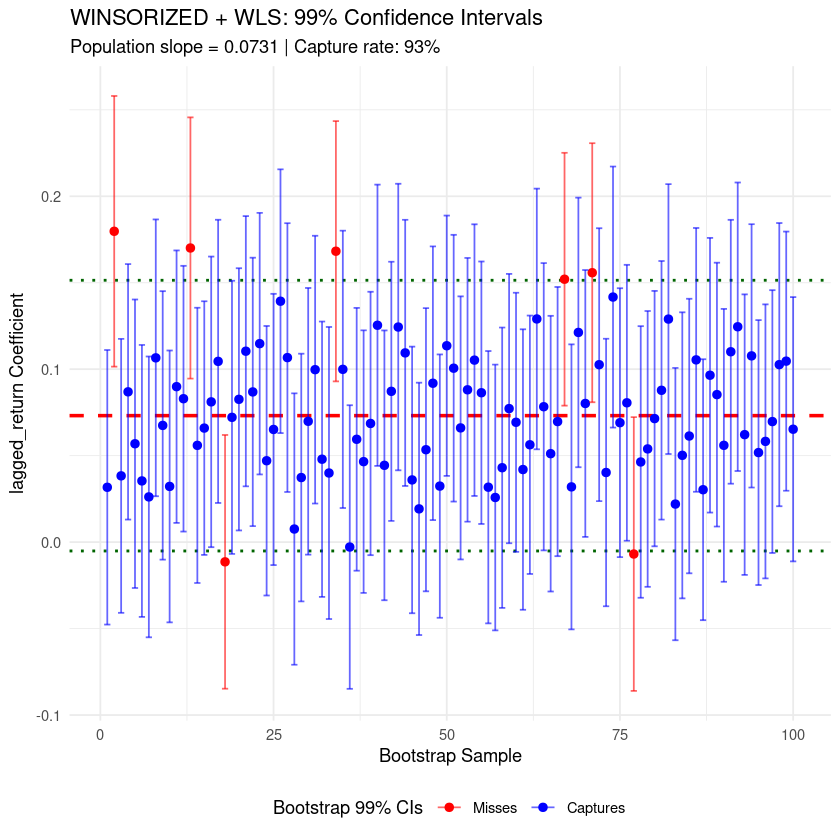

In [18]:
# ============================================================================
# BOOTSTRAP CONFIDENCE INTERVALS - WINSORIZED + WLS
# ============================================================================

cat("\n")
cat("=", rep("=", 70), "\n", sep = "")
cat("  99% CI BOOTSTRAP - WINSORIZED + WLS\n")
cat("=", rep("=", 70), "\n\n", sep = "")

# Fit the main model (winsorized + WLS)
model_full_wins <- lm(return_current_wins ~ lagged_volatility_wins + lagged_return_wins,
                      data = panel_data_clean,
                      weights = 1 / (lagged_volatility_wins^2 + 0.01))

population_coef_wins <- coef(model_full_wins)["lagged_return_wins"]
population_se_wins <- summary(model_full_wins)$coefficients["lagged_return_wins", "Std. Error"]

# Calculate 99% CI for the full dataset
population_ci_lower_wins <- population_coef_wins - z_99 * population_se_wins
population_ci_upper_wins <- population_coef_wins + z_99 * population_se_wins

cat(sprintf("FULL DATASET (Winsorized + WLS):\n"))
cat(sprintf("  Coefficient:  %.6f\n", population_coef_wins))
cat(sprintf("  Std Error:    %.6f\n", population_se_wins))
cat(sprintf("  99%% CI:       [%.6f, %.6f]\n\n", population_ci_lower_wins, population_ci_upper_wins))

# Bootstrap samples
set.seed(123)
bootstrap_results_wins <- data.frame()

cat("Generating", n_samples, "bootstrap samples (winsorized + WLS)...\n")

for(i in 1:n_samples) {
  sample_idx <- sample(1:nrow(panel_data_clean), replace = TRUE)
  boot_data <- panel_data_clean[sample_idx, ]
  
  boot_model <- tryCatch({
    lm(return_current_wins ~ lagged_volatility_wins + lagged_return_wins,
       data = boot_data,
       weights = 1 / (lagged_volatility_wins^2 + 0.01))
  }, error = function(e) NULL)
  
  if(!is.null(boot_model)) {
    coef_est <- coef(boot_model)["lagged_return_wins"]
    se_est <- summary(boot_model)$coefficients["lagged_return_wins", "Std. Error"]
    
    ci_lower <- coef_est - z_99 * se_est
    ci_upper <- coef_est + z_99 * se_est
    
    captures <- (ci_lower <= population_coef_wins) & (ci_upper >= population_coef_wins)
    
    bootstrap_results_wins <- rbind(bootstrap_results_wins, data.frame(
      sample = i,
      point_estimate = coef_est,
      ci_lower = ci_lower,
      ci_upper = ci_upper,
      captures = captures
    ))
  }
}

capture_rate_wins <- mean(bootstrap_results_wins$captures) * 100

cat(sprintf("\nCapture rate (winsorized + WLS): %.1f%% (%d out of %d intervals)\n\n", 
            capture_rate_wins, sum(bootstrap_results_wins$captures), nrow(bootstrap_results_wins)))

# Plot 2: Winsorized
plot2 <- ggplot(bootstrap_results_wins, aes(x = sample, y = point_estimate, color = captures)) +
  geom_hline(yintercept = population_ci_lower_wins, color = "darkgreen", linewidth = 0.8, linetype = "dotted") +
  geom_hline(yintercept = population_ci_upper_wins, color = "darkgreen", linewidth = 0.8, linetype = "dotted") +
  geom_hline(yintercept = population_coef_wins, color = "red", linewidth = 1, linetype = "dashed") +
  geom_point(size = 2) +
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), alpha = 0.6, linewidth = 0.5) +
  scale_color_manual(values = c("FALSE" = "red", "TRUE" = "blue"),
                     labels = c("Misses", "Captures"),
                     name = "Bootstrap 99% CIs") +
  labs(title = "WINSORIZED + WLS: 99% Confidence Intervals",
       subtitle = paste0("Population slope = ", round(population_coef_wins, 4), 
                        " | Capture rate: ", round(capture_rate_wins, 1), "%"),
       x = "Bootstrap Sample",
       y = "lagged_return Coefficient") +
  theme_minimal(base_size = 11) +
  theme(legend.position = "bottom")

print(plot2)

In [19]:
# ============================================
# DUAL MODEL OOS TESTING (WINSORIZED + WLS)
# ============================================

cat(rep("=", 80), "\n", sep="")
cat("  OUT-OF-SAMPLE TEST: TWO MODELS (WINSORIZED + WLS)\n")
cat(rep("=", 80), "\n\n", sep="")

# Sort by date
panel_data_clean <- panel_data_clean %>%
  arrange(date, stock_id)

# SPECIFY MODELS
model_formula <- "lagged_return_wins + lagged_volatility_wins"

cat("MODEL SPECIFICATIONS:\n")
cat("Model 1: return_current_wins ~", model_formula, "\n")
cat("Model 2: expected_return_current_wins ~", model_formula, "\n")
cat("Method: Weighted Least Squares (weights = 1/volatility²)\n\n")

# ============================================
# OOS TESTING PARAMETERS
# ============================================

unique_dates <- sort(unique(panel_data_clean$date))
n_dates <- length(unique_dates)

min_train_periods <- 30  # Minimum training quarters
test_period <- 8         # Test window size
step_size <- 1           # Step between windows

cat("OOS TESTING PARAMETERS:\n")
cat("Training window: minimum", min_train_periods, "quarters (expanding window)\n")
cat("Test window:", test_period, "quarters\n")
cat("Step size:", step_size, "quarters\n")
cat("Window type: EXPANDING (training always starts from beginning)\n\n")

cat(rep("=", 80), "\n", sep="")
cat("RUNNING OOS TEST...\n\n")

# Storage for results
window_results_return <- data.frame()
window_results_expected <- data.frame()

# EXPANDING WINDOW: training always starts from beginning
train_start_idx <- 1
train_end_idx <- min_train_periods

iteration <- 0

while(train_end_idx + test_period <= n_dates) {
  iteration <- iteration + 1
  
  # Define train and test periods
  train_dates <- unique_dates[train_start_idx:train_end_idx]
  test_start_idx <- train_end_idx + 1
  test_end_idx <- min(test_start_idx + test_period - 1, n_dates)
  test_dates <- unique_dates[test_start_idx:test_end_idx]
  
  train_data <- panel_data_clean %>% filter(date %in% train_dates)
  test_data <- panel_data_clean %>% filter(date %in% test_dates)
  
  if(nrow(test_data) < 50) {
    cat(sprintf("Window %d: SKIPPED (insufficient test data)\n\n", iteration))
    train_end_idx <- train_end_idx + step_size
    next
  }
  
  cat(sprintf("Window %d: Train [%s to %s] → Test [%s to %s]\n", 
              iteration,
              format(min(train_dates), "%Y-%m-%d"),
              format(max(train_dates), "%Y-%m-%d"),
              format(min(test_dates), "%Y-%m-%d"),
              format(max(test_dates), "%Y-%m-%d")))
  
  # ========================================
  # MODEL 1: PREDICT return_current_wins
  # ========================================
  tryCatch({
    full_formula <- as.formula(paste("return_current_wins ~", model_formula))
    model <- lm(full_formula, data = train_data,
                weights = 1 / (train_data$lagged_volatility_wins^2 + 0.01))
    
    in_sample_r2 <- summary(model)$r.squared
    in_sample_adj_r2 <- summary(model)$adj.r.squared
    
    pred <- predict(model, newdata = test_data)
    
    if(!any(is.na(pred)) && !any(is.infinite(pred))) {
      ss_res <- sum((test_data$return_current_wins - pred)^2)
      ss_tot <- sum((test_data$return_current_wins - mean(test_data$return_current_wins))^2)
      oos_r2 <- 1 - (ss_res / ss_tot)
      
      rmse <- sqrt(mean((test_data$return_current_wins - pred)^2))
      mae <- mean(abs(test_data$return_current_wins - pred))
      correlation <- cor(test_data$return_current_wins, pred)
      
      window_results_return <- rbind(window_results_return, data.frame(
        window = iteration,
        train_start_date = min(train_dates),
        train_end_date = max(train_dates),
        test_start_date = min(test_dates),
        test_end_date = max(test_dates),
        n_train = nrow(train_data),
        n_test = nrow(test_data),
        in_sample_r2 = in_sample_r2,
        in_sample_adj_r2 = in_sample_adj_r2,
        oos_r2 = oos_r2,
        rmse = rmse,
        mae = mae,
        correlation = correlation
      ))
      
      cat(sprintf("  return_current_wins:          IS R²=%.4f | OOS R²=%.4f | RMSE=%.4f\n", 
                  in_sample_r2, oos_r2, rmse))
    }
  }, error = function(e) {
    cat(sprintf("  return_current_wins:  ERROR - %s\n", e$message))
  })
  
  # ========================================
  # MODEL 2: PREDICT expected_return_current_wins
  # ========================================
  tryCatch({
    full_formula <- as.formula(paste("expected_return_current_wins ~", model_formula))
    model <- lm(full_formula, data = train_data,
                weights = 1 / (train_data$lagged_volatility_wins^2 + 0.01))
    
    in_sample_r2 <- summary(model)$r.squared
    in_sample_adj_r2 <- summary(model)$adj.r.squared
    
    pred <- predict(model, newdata = test_data)
    
    if(!any(is.na(pred)) && !any(is.infinite(pred))) {
      ss_res <- sum((test_data$expected_return_current_wins - pred)^2)
      ss_tot <- sum((test_data$expected_return_current_wins - mean(test_data$expected_return_current_wins))^2)
      oos_r2 <- 1 - (ss_res / ss_tot)
      
      rmse <- sqrt(mean((test_data$expected_return_current_wins - pred)^2))
      mae <- mean(abs(test_data$expected_return_current_wins - pred))
      correlation <- cor(test_data$expected_return_current_wins, pred)
      
      window_results_expected <- rbind(window_results_expected, data.frame(
        window = iteration,
        train_start_date = min(train_dates),
        train_end_date = max(train_dates),
        test_start_date = min(test_dates),
        test_end_date = max(test_dates),
        n_train = nrow(train_data),
        n_test = nrow(test_data),
        in_sample_r2 = in_sample_r2,
        in_sample_adj_r2 = in_sample_adj_r2,
        oos_r2 = oos_r2,
        rmse = rmse,
        mae = mae,
        correlation = correlation
      ))
      
      cat(sprintf("  expected_return_current_wins: IS R²=%.4f | OOS R²=%.4f | RMSE=%.4f\n", 
                  in_sample_r2, oos_r2, rmse))
    }
  }, error = function(e) {
    cat(sprintf("  expected_return_current_wins:  ERROR - %s\n", e$message))
  })
  
  cat("\n")
  
  # EXPANDING WINDOW: only move end forward
  train_end_idx <- train_end_idx + step_size
}

# ============================================
# RESULTS SUMMARY
# ============================================

cat(rep("=", 80), "\n", sep="")
cat("RESULTS SUMMARY\n")
cat(rep("=", 80), "\n\n", sep="")

# ========================================
# MODEL 1: return_current_wins
# ========================================

cat("MODEL 1: PREDICTING return_current_wins\n")
cat(rep("-", 80), "\n", sep="")

if(nrow(window_results_return) > 0) {
  
  cat(sprintf("Number of test windows: %d\n\n", nrow(window_results_return)))
  
  cat("IN-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_return$in_sample_r2), mean(window_results_return$in_sample_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_return$in_sample_r2), median(window_results_return$in_sample_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_return$in_sample_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n\n", min(window_results_return$in_sample_r2), max(window_results_return$in_sample_r2)))
  
  cat("OUT-OF-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_return$oos_r2), mean(window_results_return$oos_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_return$oos_r2), median(window_results_return$oos_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_return$oos_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n", min(window_results_return$oos_r2), max(window_results_return$oos_r2)))
  cat(sprintf("  Positive windows: %d/%d (%.0f%%)\n\n", 
              sum(window_results_return$oos_r2 > 0), nrow(window_results_return),
              mean(window_results_return$oos_r2 > 0)*100))
  
  cat("OTHER METRICS:\n")
  cat(sprintf("  Mean RMSE:        %.4f\n", mean(window_results_return$rmse)))
  cat(sprintf("  Mean MAE:         %.4f\n", mean(window_results_return$mae)))
  cat(sprintf("  Mean Correlation: %.4f\n\n", mean(window_results_return$correlation)))
  
  cat("DEGRADATION ANALYSIS:\n")
  degradation <- mean(window_results_return$in_sample_r2) - mean(window_results_return$oos_r2)
  degradation_pct <- (degradation / mean(window_results_return$in_sample_r2)) * 100
  cat(sprintf("  Mean in-sample R²:     %.4f (%.2f%%)\n", 
              mean(window_results_return$in_sample_r2), mean(window_results_return$in_sample_r2)*100))
  cat(sprintf("  Mean out-of-sample R²: %.4f (%.2f%%)\n", 
              mean(window_results_return$oos_r2), mean(window_results_return$oos_r2)*100))
  cat(sprintf("  Degradation:           %.4f (%.1f%% drop)\n\n", 
              degradation, degradation_pct))
  
} else {
  cat("NO VALID RESULTS OBTAINED\n\n")
}

# ========================================
# MODEL 2: expected_return_current_wins
# ========================================

cat(rep("=", 80), "\n", sep="")
cat("MODEL 2: PREDICTING expected_return_current_wins\n")
cat(rep("-", 80), "\n", sep="")

if(nrow(window_results_expected) > 0) {
  
  cat(sprintf("Number of test windows: %d\n\n", nrow(window_results_expected)))
  
  cat("IN-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_expected$in_sample_r2), mean(window_results_expected$in_sample_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_expected$in_sample_r2), median(window_results_expected$in_sample_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_expected$in_sample_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n\n", min(window_results_expected$in_sample_r2), max(window_results_expected$in_sample_r2)))
  
  cat("OUT-OF-SAMPLE R²:\n")
  cat(sprintf("  Mean:   %.4f (%.2f%%)\n", mean(window_results_expected$oos_r2), mean(window_results_expected$oos_r2)*100))
  cat(sprintf("  Median: %.4f (%.2f%%)\n", median(window_results_expected$oos_r2), median(window_results_expected$oos_r2)*100))
  cat(sprintf("  SD:     %.4f\n", sd(window_results_expected$oos_r2)))
  cat(sprintf("  Range:  [%.4f, %.4f]\n", min(window_results_expected$oos_r2), max(window_results_expected$oos_r2)))
  cat(sprintf("  Positive windows: %d/%d (%.0f%%)\n\n", 
              sum(window_results_expected$oos_r2 > 0), nrow(window_results_expected),
              mean(window_results_expected$oos_r2 > 0)*100))
  
  cat("OTHER METRICS:\n")
  cat(sprintf("  Mean RMSE:        %.4f\n", mean(window_results_expected$rmse)))
  cat(sprintf("  Mean MAE:         %.4f\n", mean(window_results_expected$mae)))
  cat(sprintf("  Mean Correlation: %.4f\n\n", mean(window_results_expected$correlation)))
  
  cat("DEGRADATION ANALYSIS:\n")
  degradation <- mean(window_results_expected$in_sample_r2) - mean(window_results_expected$oos_r2)
  degradation_pct <- (degradation / mean(window_results_expected$in_sample_r2)) * 100
  cat(sprintf("  Mean in-sample R²:     %.4f (%.2f%%)\n", 
              mean(window_results_expected$in_sample_r2), mean(window_results_expected$in_sample_r2)*100))
  cat(sprintf("  Mean out-of-sample R²: %.4f (%.2f%%)\n", 
              mean(window_results_expected$oos_r2), mean(window_results_expected$oos_r2)*100))
  cat(sprintf("  Degradation:           %.4f (%.1f%% drop)\n\n", 
              degradation, degradation_pct))
  
} else {
  cat("NO VALID RESULTS OBTAINED\n\n")
}

  OUT-OF-SAMPLE TEST: TWO MODELS (WINSORIZED + WLS)

MODEL SPECIFICATIONS:
Model 1: return_current_wins ~ lagged_return_wins + lagged_volatility_wins 
Model 2: expected_return_current_wins ~ lagged_return_wins + lagged_volatility_wins 
Method: Weighted Least Squares (weights = 1/volatility²)

OOS TESTING PARAMETERS:
Training window: minimum 30 quarters (expanding window)
Test window: 8 quarters
Step size: 1 quarters
Window type: EXPANDING (training always starts from beginning)

RUNNING OOS TEST...

Window 1: Train [2005-06-30 to 2012-09-28] → Test [2012-12-31 to 2014-09-30]
  return_current_wins:          IS R²=0.0140 | OOS R²=0.0338 | RMSE=12.5509
  expected_return_current_wins: IS R²=0.1409 | OOS R²=0.6069 | RMSE=1.8206

Window 2: Train [2005-06-30 to 2012-12-31] → Test [2013-03-28 to 2014-12-31]
  return_current_wins:          IS R²=0.0194 | OOS R²=-0.0222 | RMSE=11.6156
  expected_return_current_wins: IS R²=0.1414 | OOS R²=0.6223 | RMSE=1.8314

Window 3: Train [2005-06-30 to 2013-

In [20]:
# ============================================================================
# INCREMENTAL R² ANALYSIS (WINSORIZED + WLS)
# ============================================================================

# Model 1: Just lagged_volatility
model_vol_only <- lm(expected_return_current_wins ~ lagged_volatility_wins, 
                     data = panel_data_clean,
                     weights = 1 / (lagged_volatility_wins^2 + 0.01))
r2_vol_only <- summary(model_vol_only)$r.squared

# Model 2: Both lagged_return and lagged_volatility
model_both <- lm(expected_return_current_wins ~ lagged_return_wins + lagged_volatility_wins, 
                 data = panel_data_clean,
                 weights = 1 / (lagged_volatility_wins^2 + 0.01))
r2_both <- summary(model_both)$r.squared

# Model 3: Just lagged_return (for comparison)
model_return_only <- lm(expected_return_current_wins ~ lagged_return_wins, 
                        data = panel_data_clean,
                        weights = 1 / (lagged_volatility_wins^2 + 0.01))
r2_return_only <- summary(model_return_only)$r.squared

# Calculate incremental R²
delta_r2_return <- r2_both - r2_vol_only
delta_r2_vol <- r2_both - r2_return_only

# Display results
cat("\n=== INCREMENTAL R² ANALYSIS (WINSORIZED + WLS) ===\n\n")
cat(sprintf("Model with lagged_volatility only:  R² = %.4f (%.2f%%)\n", 
            r2_vol_only, r2_vol_only*100))
cat(sprintf("Model with lagged_return only:      R² = %.4f (%.2f%%)\n", 
            r2_return_only, r2_return_only*100))
cat(sprintf("Model with BOTH:                    R² = %.4f (%.2f%%)\n\n", 
            r2_both, r2_both*100))

cat(sprintf("Incremental R² from adding lagged_return:     %.4f (%.2f%% points)\n", 
            delta_r2_return, delta_r2_return*100))
cat(sprintf("Incremental R² from adding lagged_volatility: %.4f (%.2f%% points)\n\n", 
            delta_r2_vol, delta_r2_vol*100))

# Interpretation
if(delta_r2_return > 0.05) {
  cat(" lagged_return adds MEANINGFUL predictive power (>5% R² increase)\n")
} else {
  cat("✗ lagged_return adds WEAK predictive power (<5% R² increase)\n")
}

# F-test for significance of lagged_return
anova_result <- anova(model_vol_only, model_both)
cat(sprintf("\nF-test p-value: %.6f\n", anova_result$`Pr(>F)`[2]))
if(anova_result$`Pr(>F)`[2] < 0.05) {
  cat(" lagged_return is statistically significant (p < 0.05)\n")
} else {
  cat("✗ lagged_return is NOT statistically significant\n")
}


=== INCREMENTAL R² ANALYSIS (WINSORIZED + WLS) ===

Model with lagged_volatility only:  R² = 0.2713 (27.13%)
Model with lagged_return only:      R² = 0.0740 (7.40%)
Model with BOTH:                    R² = 0.3450 (34.50%)

Incremental R² from adding lagged_return:     0.0736 (7.36% points)
Incremental R² from adding lagged_volatility: 0.2710 (27.10% points)

 lagged_return adds MEANINGFUL predictive power (>5% R² increase)

F-test p-value: 0.000000
 lagged_return is statistically significant (p < 0.05)


In [22]:
rf <- lm(return_current ~ log(abs(expected_return_current)+1),data=panel_data_clean)
summary(rf)
f <- lm(expected_return_current ~ log(abs(return_current)+1),data=panel_data_clean)
summary(f)


Call:
lm(formula = return_current ~ log(abs(expected_return_current) + 
    1), data = panel_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.078  -9.090  -0.643   7.840  97.751 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)  
(Intercept)                             2.8591     1.7025   1.679   0.0934 .
log(abs(expected_return_current) + 1)   1.8479     0.9033   2.046   0.0410 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.48 on 1043 degrees of freedom
Multiple R-squared:  0.003997,	Adjusted R-squared:  0.003042 
F-statistic: 4.185 on 1 and 1043 DF,  p-value: 0.04102



Call:
lm(formula = expected_return_current ~ log(abs(return_current) + 
    1), data = panel_data_clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-36.376  -2.256  -0.407   1.788  54.574 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    3.1101     0.4524   6.874 1.07e-11 ***
log(abs(return_current) + 1)   1.0928     0.1854   5.896 5.04e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.412 on 1043 degrees of freedom
Multiple R-squared:  0.03225,	Adjusted R-squared:  0.03132 
F-statistic: 34.76 on 1 and 1043 DF,  p-value: 5.038e-09
